# Figure 4 - Example pipeline for analyzing ketamine whole-brain imaging data

In [1]:
#First run segmentation as described in https://github.com/mikarubi/voluseg from ligh-sheet imaging data

In [1]:
import os, sys
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import matplotlib.pyplot as plt

#from skimage import tifffile
import time
import glob, os
import scipy.stats as stats
import pandas as pd
import dask.array as da
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [3]:
#Load example dataset
#download dataset from https://drive.google.com/drive/folders/1bmiPenn6MHIY2axd7cqDP9mVGgwGdZXD?usp=sharing

In [7]:
os.listdir(r'/Users/marc/Library/CloudStorage/GoogleDrive-mduqueramirez@g.harvard.edu/My Drive/Papers/duque_et_al_ketamine/data_new_round_September_2023_whole_brain_ket/fish_raw/f1_ket_marc_20230926_140425/seg')

['untitled folder',
 'to_register_f1.nrrd',
 'affine.mat',
 'cor_results',
 '._Composite_fix_mov.avi',
 '._analysis',
 'analysis',
 'mov_mask_2.nrrd',
 'mov_mask.nrrd',
 'volume0.hdf5',
 'aligned.nrrd',
 'deform.nrrd',
 '._mask_plots',
 '._Icon\r',
 'fix_mask_2.nrrd',
 'mask_plots',
 'transforms',
 '._untitled folder',
 '._masks',
 '._transforms',
 'mean_timeseries.hdf5',
 'Composite_fix_mov.avi',
 'Composite_f1_atlas.avi',
 'parameters.pickle',
 '._cor_results',
 'matrix_log2_f1.nrrd',
 'fix_mask.nrrd',
 'masks',
 'cells0_clean.hdf5']

In [8]:
os.listdir(r'/Users/marc/Library/CloudStorage/GoogleDrive-mduqueramirez@g.harvard.edu/My Drive/Papers/duque_et_al_ketamine/data_new_round_September_2023_whole_brain_ket/fish_raw/f1_ket_marc_20230926_140425/seg/')
rootDir = '/Users/marc/Library/CloudStorage/GoogleDrive-mduqueramirez@g.harvard.edu/My Drive/Papers/duque_et_al_ketamine/data_new_round_September_2023_whole_brain_ket/fish_raw/f1_ket_marc_20230926_140425/seg/'
corDir=rootDir+'cor_results/'
if not os.path.exists(corDir):
    os.makedirs(corDir)
fName = 'cells0_clean.hdf5'
fName1 = 'volume0.hdf5'
import h5py 

a = h5py.File(rootDir +fName1,'r')

f = h5py.File(rootDir +fName,'r')
#readout component time seriﬁes and all cell series.
F=f['cell_timeseries']
base_f=f['cell_baseline']
X=f['cell_x']
Y=f['cell_y']
Z=f['cell_z']

#W=f['cell_weights'][()]
L=f['volume_id']
V=f['volume_weight']
brain_map=a['volume_mean'][:,:,:].T
V_mask=a['volume_mask'][:,:,:].T
#timeseries = a['T'][()
#[()]  forces loading instead of just a link
print(brain_map.shape)
print(V.shape)
numCells = F.shape[0]
print(numCells)
#dff_trace=(F[:,:]-base_f[:,:])/(base_f[:,:])
#dff_trace=(F[:,:]-base_f[:,:])/(base_f[:,:]-100)
#result = []
#for cell in range(cell_num):
    #result.append(average_bef_aft(cell))
#results=np.asarray(result)

(1024, 612, 81)
(1024, 612, 81)
198250


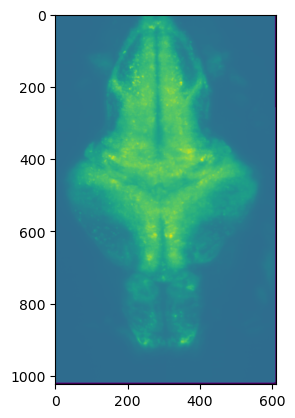

In [9]:
#for the registration
plt.imshow(np.max(brain_map[:,:,:],axis = 2))

In [10]:
to_register = np.rot90(brain_map[:,:,:],-1)

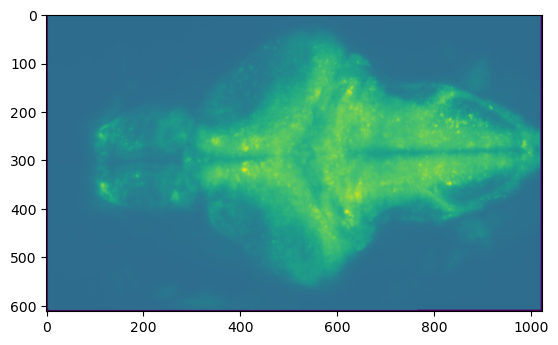

In [11]:
plt.imshow(np.max(to_register[:,:,:],axis = 2))

#### This transformation might change depending on which fish we are using, here is where we have to be careful if we want to preserve asymmetries

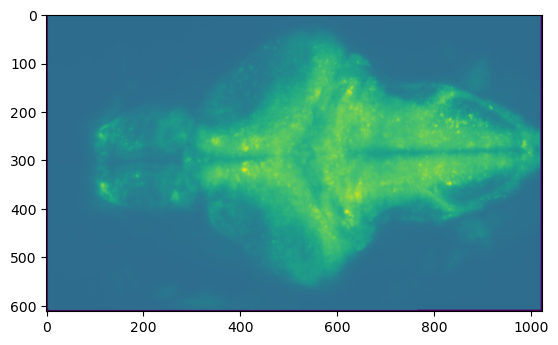

In [12]:
plt.imshow(np.max(to_register[:,:,:],axis = 2))

#### Save brain map for registration

In [53]:
import numpy as np
import nrrd
#nrrd.write('/Users/marc/Library/CloudStorage/GoogleDrive-mduqueramirez@g.harvard.edu/My Drive/data_new_round_September_2023_whole_brain_ket/f1_ket_marc_20230926_140425/seg/to_register_f1.nrrd', to_register, compression_level=2)

## The following uses bigstream to register to the ZBrain

### See https://github.com/JaneliaSciComp/bigstream for a more comprehensive description on how to use BigStream

In [15]:
import numpy as np
import nrrd

# read fixed and moving images, print shapes to make sure axes orders are consistent
fix, _ = nrrd.read('/Users/marc/Library/CloudStorage/GoogleDrive-mduqueramirez@g.harvard.edu/My Drive/Papers/duque_et_al_ketamine/data_new_round_September_2023_whole_brain_ket/fish_raw/f1_ket_marc_20230926_140425/seg/to_register_f1.nrrd')
mov, _ = nrrd.read('/Users/marc/Library/CloudStorage/GoogleDrive-mduqueramirez@g.harvard.edu/My Drive/Papers/duque_et_al_ketamine/data_new_round_September_2023_whole_brain_ket/fish_raw/f1_ket_marc_20230926_140425/seg/Elavl3-H2BRFP.nrrd')

fix = fix.astype(np.uint16)
mov = mov.astype(np.uint16)
#mov = np.transpose(mov,(1,0,2))
print(fix.shape, mov.shape)
# voxel spacings, use your own
fix_spacing = np.array([0.406*2, 0.406*2, 3.0])
mov_spacing = np.array([0.798, 0.798, 2.0])

(612, 1024, 81) (621, 1406, 138)


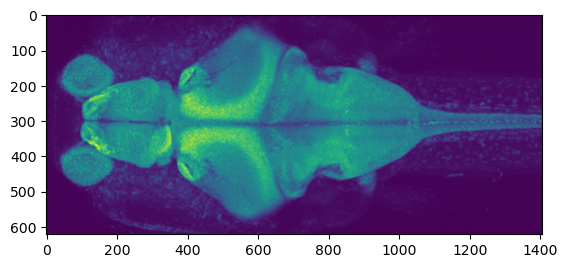

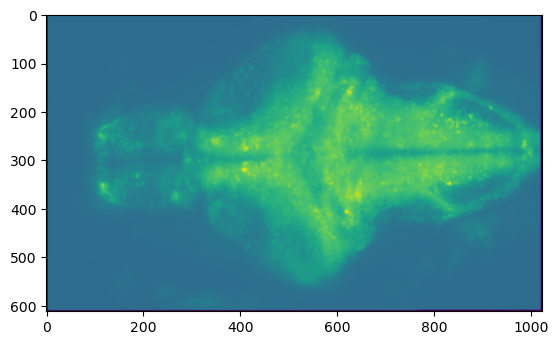

In [16]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(np.max(mov[:,:,:],axis =2))
plt.figure()
plt.imshow(np.max(fix[:,:,:],axis =2))

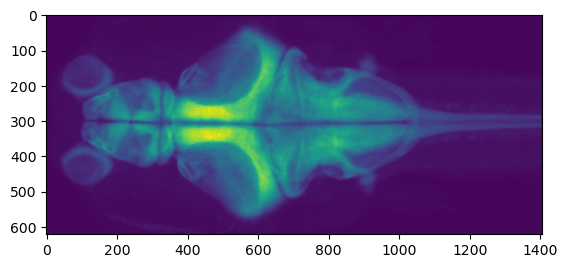

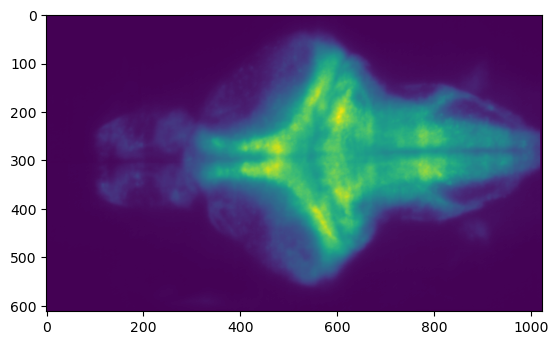

In [17]:
#match histograms
from skimage.exposure import match_histograms
fix = match_histograms(fix,mov)
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(np.mean(mov[:,:,:],axis =2))
plt.figure()
plt.imshow(np.mean(fix[:,:,:],axis =2))

## You can tweak lmabdas depending on the contrast to get the whole brain

In [4]:
# tools for coarse whole brain segmentation
from bigstream import level_set
from scipy.ndimage import zoom, binary_closing, binary_dilation

# get small mask
fix_skip = fix[::4, ::4, ::1]
skip_spacing = fix_spacing * [4, 4, 1]
fix_mask = level_set.foreground_segmentation(
    fix_skip, skip_spacing,
    mask_smoothing=1,
    iterations=[80,40,10],
    smooth_sigmas=[24,12,6],
    lambda2=10,
)

# topological corrections, and write result
fix_mask = binary_closing(fix_mask, np.ones((5,5,5))).astype(np.uint8)
fix_mask = binary_dilation(fix_mask, np.ones((5,5,5))).astype(np.uint8)
fix_mask = zoom(fix_mask, np.array(fix.shape) / fix_skip.shape, order=0)
nrrd.write('/Users/marc/Library/CloudStorage/GoogleDrive-mduqueramirez@g.harvard.edu/My Drive/Papers/duque_et_al_ketamine/data_new_round_September_2023_whole_brain_ket/fish_raw/f1_ket_marc_20230926_140425/seg/fix_mask.nrrd', fix_mask)

# get small mask
mov_skip = mov[::4, ::4, ::1]
skip_spacing = mov_spacing * [4, 4, 1]
mov_mask = level_set.foreground_segmentation(
    mov_skip, skip_spacing,
    mask_smoothing=1,
    iterations=[80,40,10],
    smooth_sigmas=[24,12,6],
    lambda2=10,
)

# topological corrections, and write result
mov_mask = binary_closing(mov_mask, np.ones((5,5,5))).astype(np.uint8)
mov_mask = binary_dilation(mov_mask, np.ones((5,5,5))).astype(np.uint8)
mov_mask = zoom(mov_mask, np.array(mov.shape) / mov_skip.shape, order=0)
nrrd.write('/Users/marc/Library/CloudStorage/GoogleDrive-mduqueramirez@g.harvard.edu/My Drive/Papers/duque_et_al_ketamine/data_new_round_September_2023_whole_brain_ket/fish_raw/f1_ket_marc_20230926_140425/seg/mov_mask.nrrd', mov_mask)



In [4]:
# load precomputed mask
fix_mask, _ = nrrd.read('/Users/marc/Library/CloudStorage/GoogleDrive-mduqueramirez@g.harvard.edu/My Drive/Papers/duque_et_al_ketamine/data_new_round_September_2023_whole_brain_ket/fish_raw/f1_ket_marc_20230926_140425/seg/fix_mask.nrrd')
mov_mask, _ = nrrd.read('/Users/marc/Library/CloudStorage/GoogleDrive-mduqueramirez@g.harvard.edu/My Drive/Papers/duque_et_al_ketamine/data_new_round_September_2023_whole_brain_ket/fish_raw/f1_ket_marc_20230926_140425/seg/mov_mask.nrrd')
print(fix_mask.shape, mov_mask.shape)


(612, 1024, 81) (621, 1406, 138)


In [6]:
from bigstream.align import alignment_pipeline
from bigstream.transform import apply_transform

In [5]:


# define parameters for an affine + deformable alignment
affine_kwargs = {
    'alignment_spacing':2.0,
    'shrink_factors':(2,),
    'smooth_sigmas':(8.,),
    'optimizer_args':{
        'learningRate':0.8,
        'minStep':0,
        'numberOfIterations':1500,
    },
}

deform_kwargs = {
    'alignment_spacing':2.0,
    'shrink_factors':(2,),
    'smooth_sigmas':(8.,),
    'control_point_spacing':100.0,
    'control_point_levels':(1,),
    'optimizer_args':{
        'learningRate':0.5,
        'minStep':0.01,
        'numberOfIterations':1500,
    },
    
    
    'fix_mask':fix_mask,
    'mov_mask':mov_mask,
}

steps = [('affine', affine_kwargs),
         ('deform', deform_kwargs),]

# execute the alignment, return affine and deformable components as independent objects
affine, deform = alignment_pipeline(
    fix, mov, fix_spacing, mov_spacing, steps,
    return_format='independent',
)

# apply transforms to moving data
aligned = apply_transform(
    fix, mov, fix_spacing, mov_spacing,
    transform_list=[affine, deform],
)

# write the results
nrrd.write('/Users/marc/Library/CloudStorage/GoogleDrive-mduqueramirez@g.harvard.edu/My Drive/Papers/duque_et_al_ketamine/data_new_round_September_2023_whole_brain_ket/fish_raw/f1_ket_marc_20230926_140425/seg/aligned.nrrd', aligned, compression_level=2)
np.savetxt('/Users/marc/Library/CloudStorage/GoogleDrive-mduqueramirez@g.harvard.edu/My Drive/Papers/duque_et_al_ketamine/data_new_round_September_2023_whole_brain_ket/fish_raw/f1_ket_marc_20230926_140425/seg/affine.mat', affine)
nrrd.write('/Users/marc/Library/CloudStorage/GoogleDrive-mduqueramirez@g.harvard.edu/My Drive/Papers/duque_et_al_ketamine/data_new_round_September_2023_whole_brain_ket/fish_raw/f1_ket_marc_20230926_140425/seg/deform.nrrd', deform, compression_level=2)

LEVEL:  0  ITERATION:  0  METRIC:  -0.21548270256355156
LEVEL:  0  ITERATION:  1  METRIC:  -0.21992187830824791
LEVEL:  0  ITERATION:  2  METRIC:  -0.22460050734760348
LEVEL:  0  ITERATION:  3  METRIC:  -0.22952063001059342
LEVEL:  0  ITERATION:  4  METRIC:  -0.23454892549677536
LEVEL:  0  ITERATION:  5  METRIC:  -0.23983093913215894
LEVEL:  0  ITERATION:  6  METRIC:  -0.24532070568707048
LEVEL:  0  ITERATION:  7  METRIC:  -0.2510078382377329
LEVEL:  0  ITERATION:  8  METRIC:  -0.2568736155868816
LEVEL:  0  ITERATION:  9  METRIC:  -0.2628659530292919
LEVEL:  0  ITERATION:  10  METRIC:  -0.2690709894366908
LEVEL:  0  ITERATION:  11  METRIC:  -0.2755676978283139
LEVEL:  0  ITERATION:  12  METRIC:  -0.28224929233818763
LEVEL:  0  ITERATION:  13  METRIC:  -0.2891795414402363
LEVEL:  0  ITERATION:  14  METRIC:  -0.2963813388969799
LEVEL:  0  ITERATION:  15  METRIC:  -0.30394542106856115
LEVEL:  0  ITERATION:  16  METRIC:  -0.31183477556794087
LEVEL:  0  ITERATION:  17  METRIC:  -0.320016265

### Get inverse transforms (if needed)

In [1]:
import numpy as np
import nrrd

# read fixed and moving images, print shapes to make sure axes orders are consistent
fix, _ = nrrd.read('/Users/marc/Library/CloudStorage/GoogleDrive-mduqueramirez@g.harvard.edu/My Drive/Papers/duque_et_al_ketamine/data_new_round_September_2023_whole_brain_ket/fish_raw/f1_ket_marc_20230926_140425/seg/to_register_f1.nrrd')
mov, _ = nrrd.read('/Users/marc/Library/CloudStorage/GoogleDrive-mduqueramirez@g.harvard.edu/My Drive/Papers/duque_et_al_ketamine/data_new_round_September_2023_whole_brain_ket/fish_raw/f1_ket_marc_20230926_140425/seg/Elavl3-H2BRFP.nrrd')
fix = fix.astype(np.uint16)
mov = mov.astype(np.uint16)
#mov = np.transpose(mov,(1,0,2))
print(fix.shape, mov.shape)
# voxel spacings
fix_spacing = np.array([0.406*2, 0.406*2, 4.0])
mov_spacing = np.array([0.798, 0.798, 2.0])
# invert transforms for fish 1
deform, _ = nrrd.read('/Users/marc/Library/CloudStorage/GoogleDrive-mduqueramirez@g.harvard.edu/My Drive/Papers/duque_et_al_ketamine/data_new_round_September_2023_whole_brain_ket/fish_raw/f1_ket_marc_20230926_140425/seg/deform.nrrd')
affine = np.loadtxt('/Users/marc/Library/CloudStorage/GoogleDrive-mduqueramirez@g.harvard.edu/My Drive/Papers/duque_et_al_ketamine/data_new_round_September_2023_whole_brain_ket/fish_raw/f1_ket_marc_20230926_140425/seg/affine.mat')

(612, 1024, 81) (621, 1406, 138)


In [ ]:

from bigstream.transform import invert_displacement_vector_field
# invert the transforms

affine_inverse = np.linalg.inv(affine)
deform_inverse = invert_displacement_vector_field(deform, fix_spacing)


nrrd.write('/Users/marc/Library/CloudStorage/GoogleDrive-mduqueramirez@g.harvard.edu/My Drive/Papers/duque_et_al_ketamine/data_new_round_September_2023_whole_brain_ket/fish_raw/f1_ket_marc_20230926_140425/seg/deform_inverse.nrrd', deform_inverse, compression_level=2)
np.savetxt('/Users/marc/Library/CloudStorage/GoogleDrive-mduqueramirez@g.harvard.edu/My Drive/Papers/duque_et_al_ketamine/data_new_round_September_2023_whole_brain_ket/fish_raw/f1_ket_marc_20230926_140425/seg/affine_inverse.mat', affine_inverse)

In [ ]:
# Check the quality of the alignment by comparing aligned with fix - there's a video for f1 in the folder Composite_fix_mov.avi

## Apply transform to atlas masks

In [3]:
from os import listdir
from os.path import isfile, join
#Read original Z-Brain masks
mypath = '/Users/marc/Library/CloudStorage/GoogleDrive-mduqueramirez@g.harvard.edu/My Drive/Papers/duque_et_al_ketamine/data_new_round_September_2023_whole_brain_ket/fish_raw/f1_ket_marc_20230926_140425/seg/region_masks_z_brain_Sep_2023'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [8]:
#Wrap original ZBrain mask into the fish to perform mask specific analysis
for mask in onlyfiles:
# read labels
    try:
        print(mask)
        labels, _ = nrrd.read(join(mypath, mask))
        print(mov.shape, labels.shape)

        # warp them to subject
        labels_subject = apply_transform(
            fix, labels, mov_spacing,fix_spacing,
            transform_list=[affine,deform],
            transform_spacing=(fix_spacing, fix_spacing),
        )
        print(fix.shape, labels_subject.shape)

        # write result
        name = join(mypath, mask)
        nrrd.write('/Users/marc/Library/CloudStorage/GoogleDrive-mduqueramirez@g.harvard.edu/My Drive/Papers/duque_et_al_ketamine/data_new_round_September_2023_whole_brain_ket/fish_raw/f1_ket_marc_20230926_140425/seg/masks/' + mask, labels_subject, compression_level=2)
    except:
        pass

Diencephalon - Hypothalamus Hcrt Neurons.nrrd
(621, 1406, 138) (621, 1406, 138)
(612, 1024, 81) (612, 1024, 81)


# Now mask specific analysis

## Going back to dF/F

In [2]:
os.listdir(r'/Users/marc/Library/CloudStorage/GoogleDrive-mduqueramirez@g.harvard.edu/My Drive/Papers/duque_et_al_ketamine/data_new_round_September_2023_whole_brain_ket/fish_raw/f1_ket_marc_20230926_140425/seg')
rootDir = r'/Users/marc/Library/CloudStorage/GoogleDrive-mduqueramirez@g.harvard.edu/My Drive/Papers/duque_et_al_ketamine/data_new_round_September_2023_whole_brain_ket/fish_raw/f1_ket_marc_20230926_140425/seg/'

fName = 'cells0_clean.hdf5'
fName1 = 'volume0.hdf5'
import h5py 

a = h5py.File(rootDir +fName1,'r')

f = h5py.File(rootDir +fName,'r')
#readout component time seriﬁes and all cell series.
F=f['cell_timeseries']
base_f=f['cell_baseline']
X=f['cell_x']
Y=f['cell_y']
Z=f['cell_z']

W=f['cell_weights'][()]
L=f['volume_id']
V=f['volume_weight']
brain_map=a['volume_mean'][:,:,:].T
V_mask=a['volume_mask'][:,:,:].T
#timeseries = a['T'][()
#[()]  forces loading instead of just a link
print(brain_map.shape)
print(V.shape)
numCells = F.shape[0]
print(numCells)
#dff_trace=(F[:,:]-base_f[:,:])/(base_f[:,:])
#dff_trace=(F[:,:]-base_f[:,:])/(base_f[:,:]-100)
#result = []
#for cell in range(cell_num):
    #result.append(average_bef_aft(cell))
#results=np.asarray(result)

(1024, 612, 81)
(1024, 612, 81)
198250


In [3]:
#Function to calculate dFF
def dff(data, window=300, percentile=5, downsample=1):
    """
    Estimate delta-f / f_baseline with the option to downsample
    
    data : 1D numpy array
        Data to be processed
        
    window : int
        Window size for baseline estimation. If downsampling is used, window will shrink proportionally
        
    percentile : int
        Percentile used as baseline
    
    downsample : int
        Rate of downsampling used before estimating baseline. For no downsampling, use downsample=1.
    """
    
    from scipy.signal import decimate
    from scipy.ndimage.filters import percentile_filter
    from numpy import interp
    
    if downsample == 1:
        baseline = percentile_filter(data, percentile=percentile, size=window)
    else:
        data_ds = decimate(data, downsample, ftype='iir', zero_phase=True)
        # using decimate with the default filter shifts the output by ~1-2% relative to the input. 
        # correct for baseline shift by adding a small constant to data_ds
        data_ds += data.min() - data_ds.min()
        baseline_ds = percentile_filter(data_ds, percentile=percentile, size=window//downsample)
        
        baseline = interp(range(0, len(data)), range(0, len(data), downsample), baseline_ds)
    
    return (data - baseline) / baseline

In [4]:
#Use multiprocessing to calculate dff
from multiprocessing import Pool
import multiprocessing
import multiprocess as mp

from multiprocessing import cpu_count

num_workers=cpu_count()

if __name__ == '__main__':
    with mp.Pool(num_workers) as p:
        result=p.map(dff, F)
        p.close()
       # plt.plot(dff_trace[6,:])
dff=np.asarray(result)

In [5]:
dF_z = np.zeros((F.shape))


#new dFF
for cell in range(F.shape[0]):
    dF_z[cell,:] = (dff[cell,:] - np.mean(dff[cell,0:200])) / (np.std(dff[cell,0:200]))

In [6]:
numCells = dff.shape[0]
auc=np.zeros((F.shape[0]))
num_workers=cpu_count()
def early_response(x):
    a = np.nanmean(dff[x,0:600])
    b = np.nanmean(dff[x,600:1000])
    auc[x] = 0
    if max(dff[x,:]) > 100 or min(dff[x,:] < -100):
        pass
    else:
        auc[x] = np.log2(b/a)
    return auc[x]
if __name__ == '__main__':
    with mp.Pool(num_workers) as p:
        result=p.map(early_response, range(numCells))
        p.close()
       # plt.plot(dff_trace[6,:])
results_early=np.asarray(result)

In [7]:
numCells = dff.shape[0]
auc=np.zeros((F.shape[0]))
num_workers=cpu_count()
def overall_response(x):
    a = np.nanmean(dff[x,0:600])
    b = np.nanmean(dff[x,600:])
    auc[x] = 0
    if max(dff[x,:]) > 100 or min(dff[x,:] < -100):
        pass
    else:
        auc[x] = np.log2(b/a)
    return auc[x]
if __name__ == '__main__':
    with mp.Pool(num_workers) as p:
        result=p.map(overall_response, range(numCells))
        p.close()
       # plt.plot(dff_trace[6,:])
results_overall=np.asarray(result)

In [8]:
numCells = dff.shape[0]
auc=np.zeros((F.shape[0]))
num_workers=cpu_count()
def late_response(x):
    a = np.nanmean(dff[x,0:600])
    b = np.nanmean(dff[x,1000:])
    auc[x] = 0
    if max(dff[x,:]) > 100 or min(dff[x,:] < -100):
        pass
    else:
        auc[x] = np.log2(b/a)
    return auc[x]
if __name__ == '__main__':
    with mp.Pool(num_workers) as p:
        result=p.map(late_response, range(numCells))
        p.close()
       # plt.plot(dff_trace[6,:])
results_late=np.asarray(result)

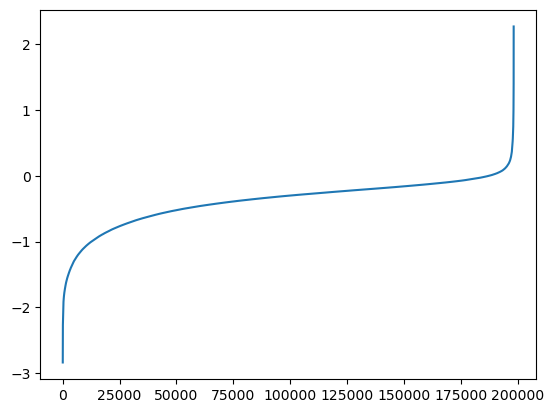

In [9]:
max_late = results_overall
#before_ind=np.argsort(before)
#after_ind=np.argsort(after)|
max_ind_late=np.argsort(max_late)
sorted_max_late=max_late[max_ind_late]
plt.figure()
#plt.plot(max_
#plt.figure()
plt.plot(sorted_max_late)
#plt.ylim(-0.5,0.5)

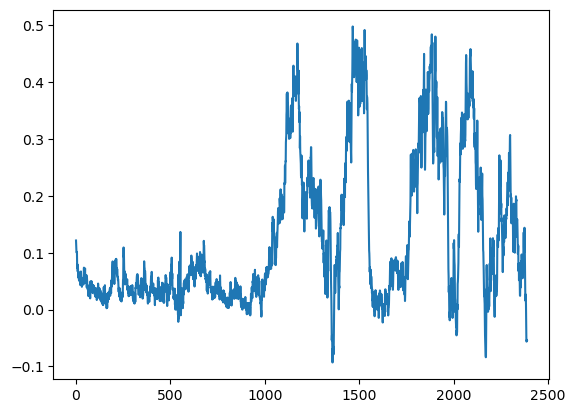

In [23]:
plt.plot(dff[max_ind_late[-4],:])

## Modify or add back more parameters

### Before moving on, check that the actual registration worked and was applied to the masks in a proper way

In [17]:
import numpy as np
import nrrd
ref, _ = nrrd.read('/Users/marc/Library/CloudStorage/GoogleDrive-mduqueramirez@g.harvard.edu/My Drive/Papers/duque_et_al_ketamine/data_new_round_September_2023_whole_brain_ket/fish_raw/f1_ket_marc_20230926_140425/seg/to_register_f1.nrrd')

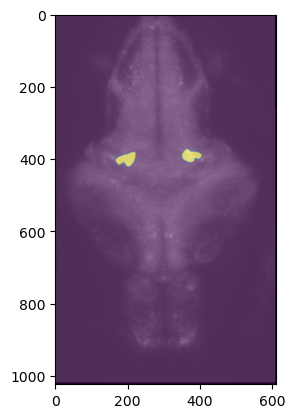

In [19]:
import nrrd
mask = 'Rhombencephalon - Locus Coreuleus'
directory = mask
parent_dir = '/Users/marc/Library/CloudStorage/GoogleDrive-mduqueramirez@g.harvard.edu/My Drive/Papers/duque_et_al_ketamine/data_new_round_September_2023_whole_brain_ket/fish_raw/f1_ket_marc_20230926_140425/seg/masks'
# Path
path = os.path.join(parent_dir, directory)
#os.mkdir(path)
LC, _ = nrrd.read('/Users/marc/Library/CloudStorage/GoogleDrive-mduqueramirez@g.harvard.edu/My Drive/Papers/duque_et_al_ketamine/data_new_round_September_2023_whole_brain_ket/fish_raw/f1_ket_marc_20230926_140425/seg/masks/'+mask+'.nrrd')
#npad = ((240, 204), (0, 0), (0, 0))
#b = np.pad(LC, pad_width=npad)
mask_LC = np.rot90((LC[:,:,:]),1)
plt.imshow(np.max(brain_map,axis=2),cmap = 'gray')
plt.imshow(np.max(mask_LC,axis=2),alpha = 0.5,cmap='viridis')

# Plot the the average trace for the top 5% 

In [20]:
masks = ['Rhombencephalon - Cerebellum',
'Rhombencephalon - Interpeduncular Nucleus'
,'Ganglia - Olfactory Epithelium',
'Telencephalon - Olfactory Bulb',
'Rhombencephalon - Lateral Reticular Nucleus',
'Rhombencephalon - Raphe - Superior',
'Diencephalon - Caudal Hypothalamus',
'Rhombencephalon - Area Postrema',
'Rhombencephalon - Noradrendergic neurons of the Interfascicular and Vagal areas']

### Let's use the superior raphe as an example

In [26]:
mask_names = ['Rhombencephalon - Raphe - Superior']

In [27]:
from multiprocessing import Pool
import multiprocessing
import multiprocess as mp
import scipy
import nrrd
from multiprocessing import cpu_count
i = 0

def in_mask(i):


    correct = np.any((mask_LC[X[i],Y[i],Z[i]]==255))

    return correct
for mask in mask_names:
    print(str(i)+"/294")
    directory = mask
    parent_dir = '/Users/marc/Library/CloudStorage/GoogleDrive-mduqueramirez@g.harvard.edu/My Drive/Papers/duque_et_al_ketamine/data_new_round_September_2023_whole_brain_ket/fish_raw/f1_ket_marc_20230926_140425/seg/analysis'
    # Path
    LC, _ = nrrd.read('/Users/marc/Library/CloudStorage/GoogleDrive-mduqueramirez@g.harvard.edu/My Drive/Papers/duque_et_al_ketamine/data_new_round_September_2023_whole_brain_ket/fish_raw/f1_ket_marc_20230926_140425/seg/masks/'+mask+'.nrrd')
    #npad = ((240, 204), (0, 0), (0, 0))
    #b = np.pad(LC, pad_width=npad)
    #this part can be specific for each fish
    mask_LC = np.rot90((LC[:,:,:]),1)
    plt.imshow(np.max(brain_map,axis=2),cmap = 'gray')
    plt.imshow(np.max(mask_LC,axis=2),alpha = 0.5,cmap='viridis')
    #plt.savefig(path+'/mask_overlay.pdf')  
    plt.clf()
    num_workers=cpu_count()

    if __name__ == '__main__':
        with mp.Pool(num_workers) as p:
            result=p.map(in_mask, range(len(X)))
            p.close()
           # plt.plot(dff_trace[6,:])
    results=np.asarray(result)
    LC_inds = np.where(results)[0]
    dff_LC = dff[LC_inds,:]
    #dff_LC = dF_new
    i = i +1
    if len(LC_inds) ==0:
        pass
    else:
            #before=results[:,0]
        #after=results[:,1]
        #normalize
        max_ = results_overall[LC_inds]
        #before_ind=np.argsort(before)
        #after_ind=np.argsort(after)|
        max_ind=np.argsort(max_)
        sorted_max=max_[max_ind]
        #plt.figure()
        #plt.plot(max_)
        #plt.figure()
        #plt.plot(sorted_max)
        #plt.ylim(0,1)

        try:
            dFs = []
            top = 10
            for i in range(top):
                print(top-i)
                dFs.append(dff_LC[max_ind[-(top-i)],:])

        except:
            pass
        #add the heatmap

0/294
10
9
8
7
6
5
4
3
2
1


<Figure size 640x480 with 0 Axes>

In [127]:
dFs_f3_RS = dFs

In [124]:
dFs_f3_AP = dFs

In [35]:
np.shape(dFs)

(10, 2390)

In [28]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [29]:
errors = np.std(dFs, axis = 0)
y = np.mean(dFs, axis = 0)

In [30]:
y_3 =  moving_average(y, 10)


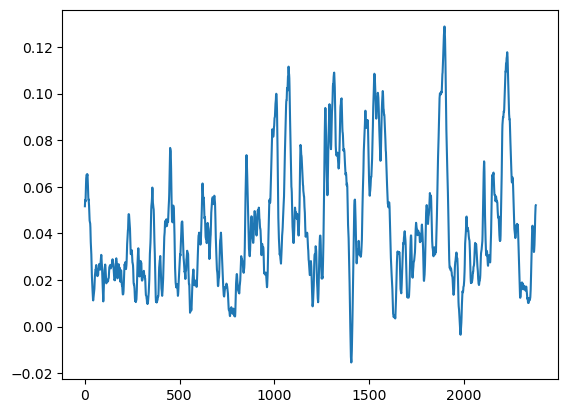

In [31]:
plt.plot(y_3)

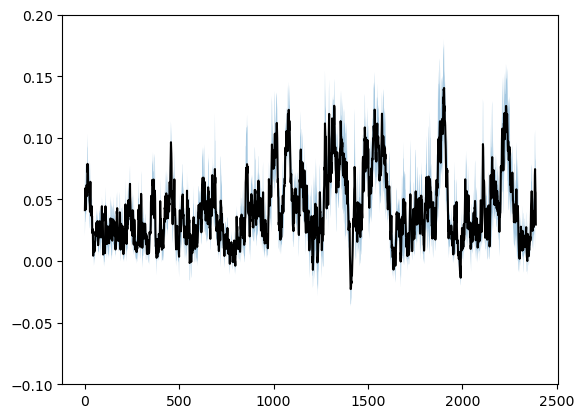

In [37]:
x = np.asarray(list(range(len(y))))
#y = np.mean(dFs, axis = 0)
y = np.mean(dFs, axis = 0)
error = np.std(dFs, axis = 0)

plt.plot(x, y,'k')
plt.fill_between(x, y-error, y+error, alpha = 0.4)
plt.ylim([-0.1,0.2])
plt.show()

### Now do it for all the masks

In [15]:
from os import listdir
from os.path import isfile, join
mypath = '/Users/marc/Library/CloudStorage/GoogleDrive-mduqueramirez@g.harvard.edu/My Drive/Papers/duque_et_al_ketamine/data_new_round_September_2023_whole_brain_ket/fish_raw/f1_ket_marc_20230926_140425/seg/masks'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
mask_names  = []
for element in onlyfiles:
    mask_names.append(os.path.splitext(element)[0])

In [49]:
mask_names

['Rhombencephalon - Glyt2 Cluster 6',
 'Diencephalon - Oxtl Cluster 5',
 'Mesencephalon - Vglut2 cluster 1',
 'Rhombencephalon - MiV2',
 'Rhombencephalon - Otpb Cluster 1',
 'Spinal Cord - Vglut2 Stripe 1',
 'Rhombencephalon - Neuropil Region 5',
 'Rhombencephalon - Inferior Olive',
 'Rhombencephalon - Cerebellum',
 "Rhombencephalon - VII' Facial Motor and octavolateralis efferent neurons",
 'Rhombencephalon - Gad1b Cluster 16',
 'Diencephalon - Oxtl Cluster 4 - sparse in hypothalamus',
 'Diencephalon - Retinal Arborization Field 1 (AF1, Approximate Location)',
 'Rhombencephalon - Vmat2 Cluster 3',
 'Rhombencephalon - Olig2 Stripe',
 'Telencephalon - Anterior Commisure',
 'Ganglia - Vagal Ganglia',
 'Mesencephalon - Torus Semicircularis',
 'Mesencephalon - Sparse 6.7FRhcrtR cluster',
 'Diencephalon - Hypothalamus Olig2 cluster 2',
 'Rhombencephalon - Gad1b Cluster 20',
 'Rhombencephalon - Glyt2 Cluster 10',
 'Rhombencephalon - Oxtl Cluster 2 Near MC axon cap',
 'Rhombencephalon - Gad1b

## adjust plotting if anything changes (i.e duration of experiment etc)

0/294
1/294
2/294
3/294
4/294
5/294
6/294
7/294
8/294
9/294
10/294
11/294
12/294
13/294
14/294
15/294
16/294
17/294
18/294
19/294
20/294
21/294
22/294
23/294
24/294
25/294
26/294
27/294
28/294
29/294
30/294
31/294
32/294
33/294
34/294
35/294
36/294
37/294
38/294
39/294
40/294
41/294
42/294
43/294
44/294
45/294
46/294
47/294
48/294
49/294
50/294
51/294
52/294
53/294
54/294
55/294
56/294
57/294
58/294
59/294
60/294
61/294
62/294
63/294
64/294
65/294
66/294
67/294
68/294
69/294
70/294
71/294
72/294
73/294
74/294
75/294
76/294
77/294
78/294
79/294
80/294
81/294
82/294
83/294
84/294
85/294
86/294
87/294
88/294
89/294
90/294
91/294
92/294
93/294
94/294
95/294
96/294
97/294
98/294
99/294
100/294
101/294
102/294
103/294
104/294
105/294
106/294
107/294
108/294
109/294
110/294
111/294
112/294
113/294
114/294
115/294
116/294
117/294
118/294
119/294
120/294
121/294
122/294
123/294
124/294
125/294
126/294
127/294
128/294
129/294
130/294
131/294
132/294
133/294
134/294
135/294
136/294
137/294
138/29

<Figure size 640x480 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

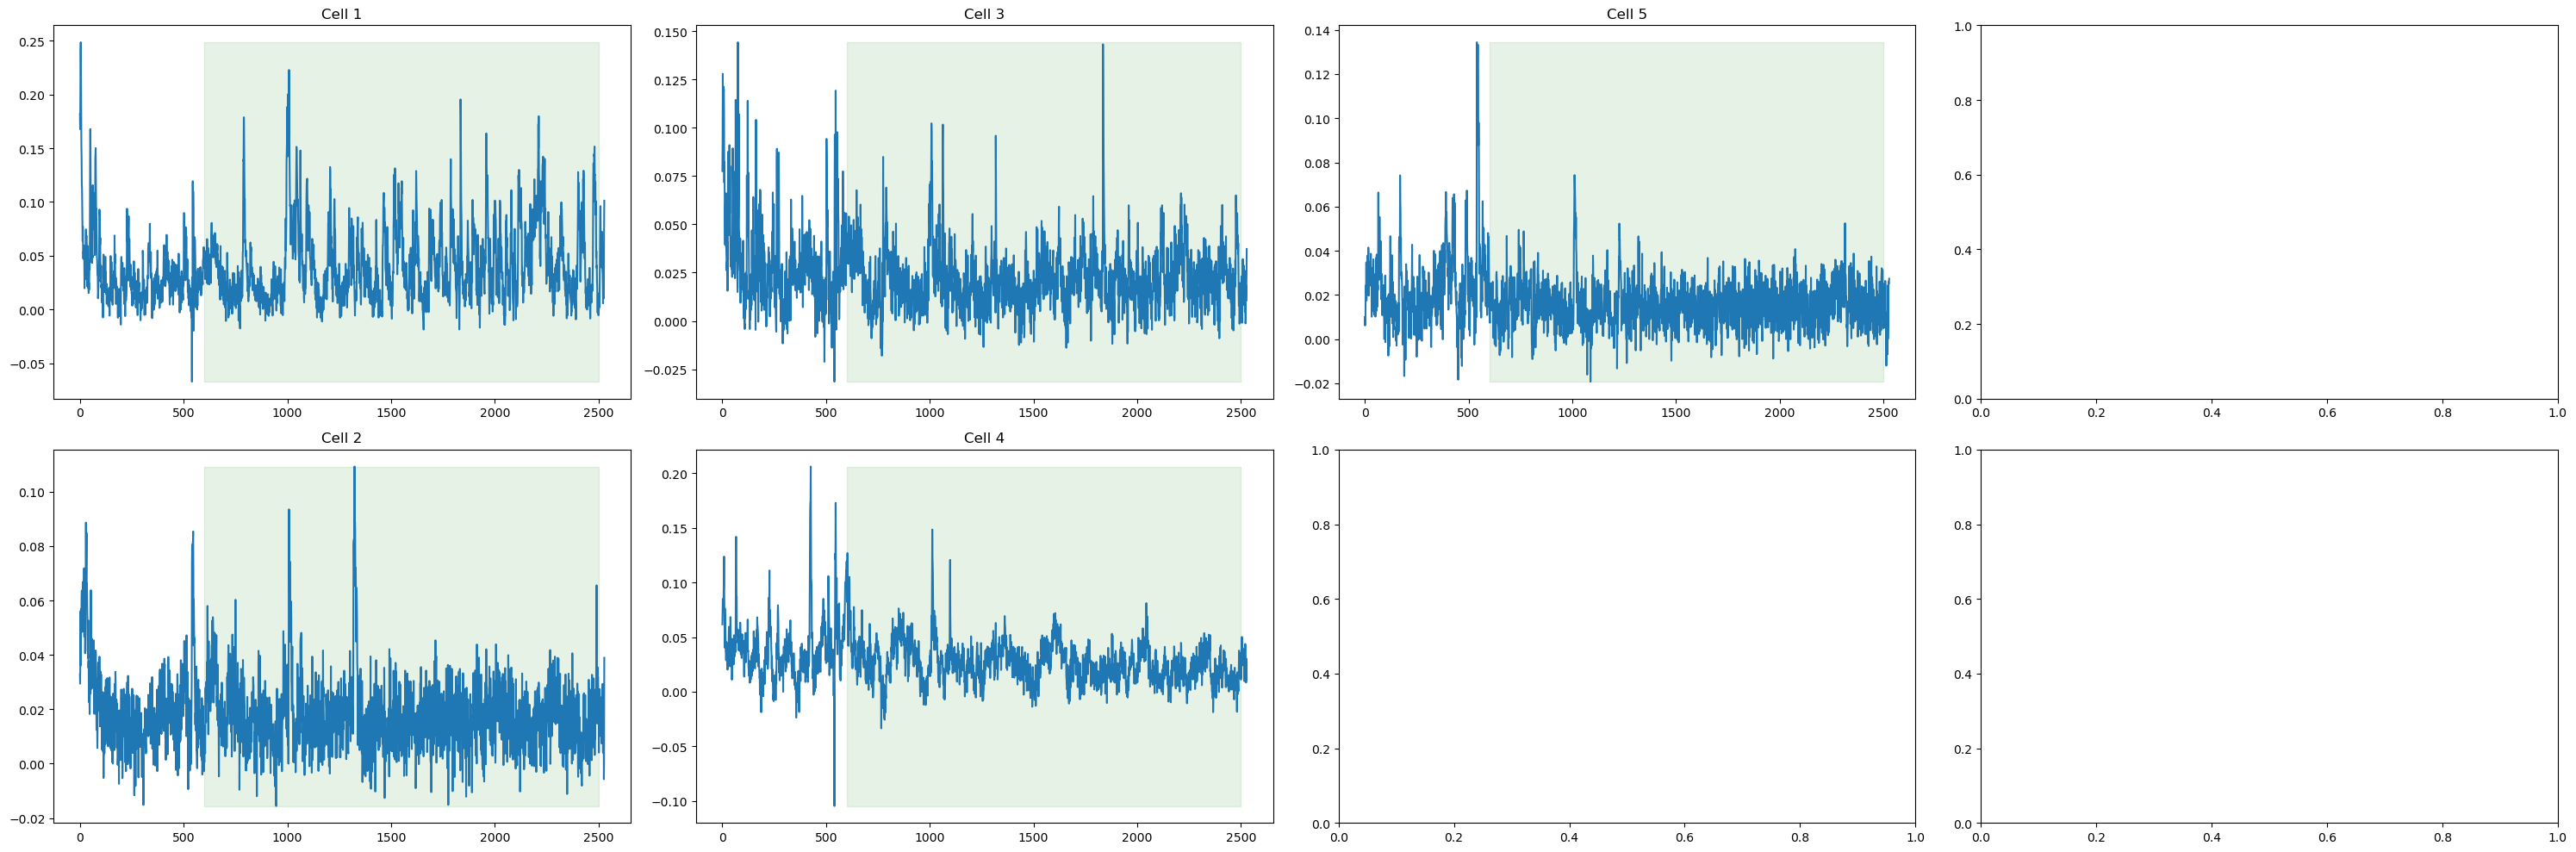

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

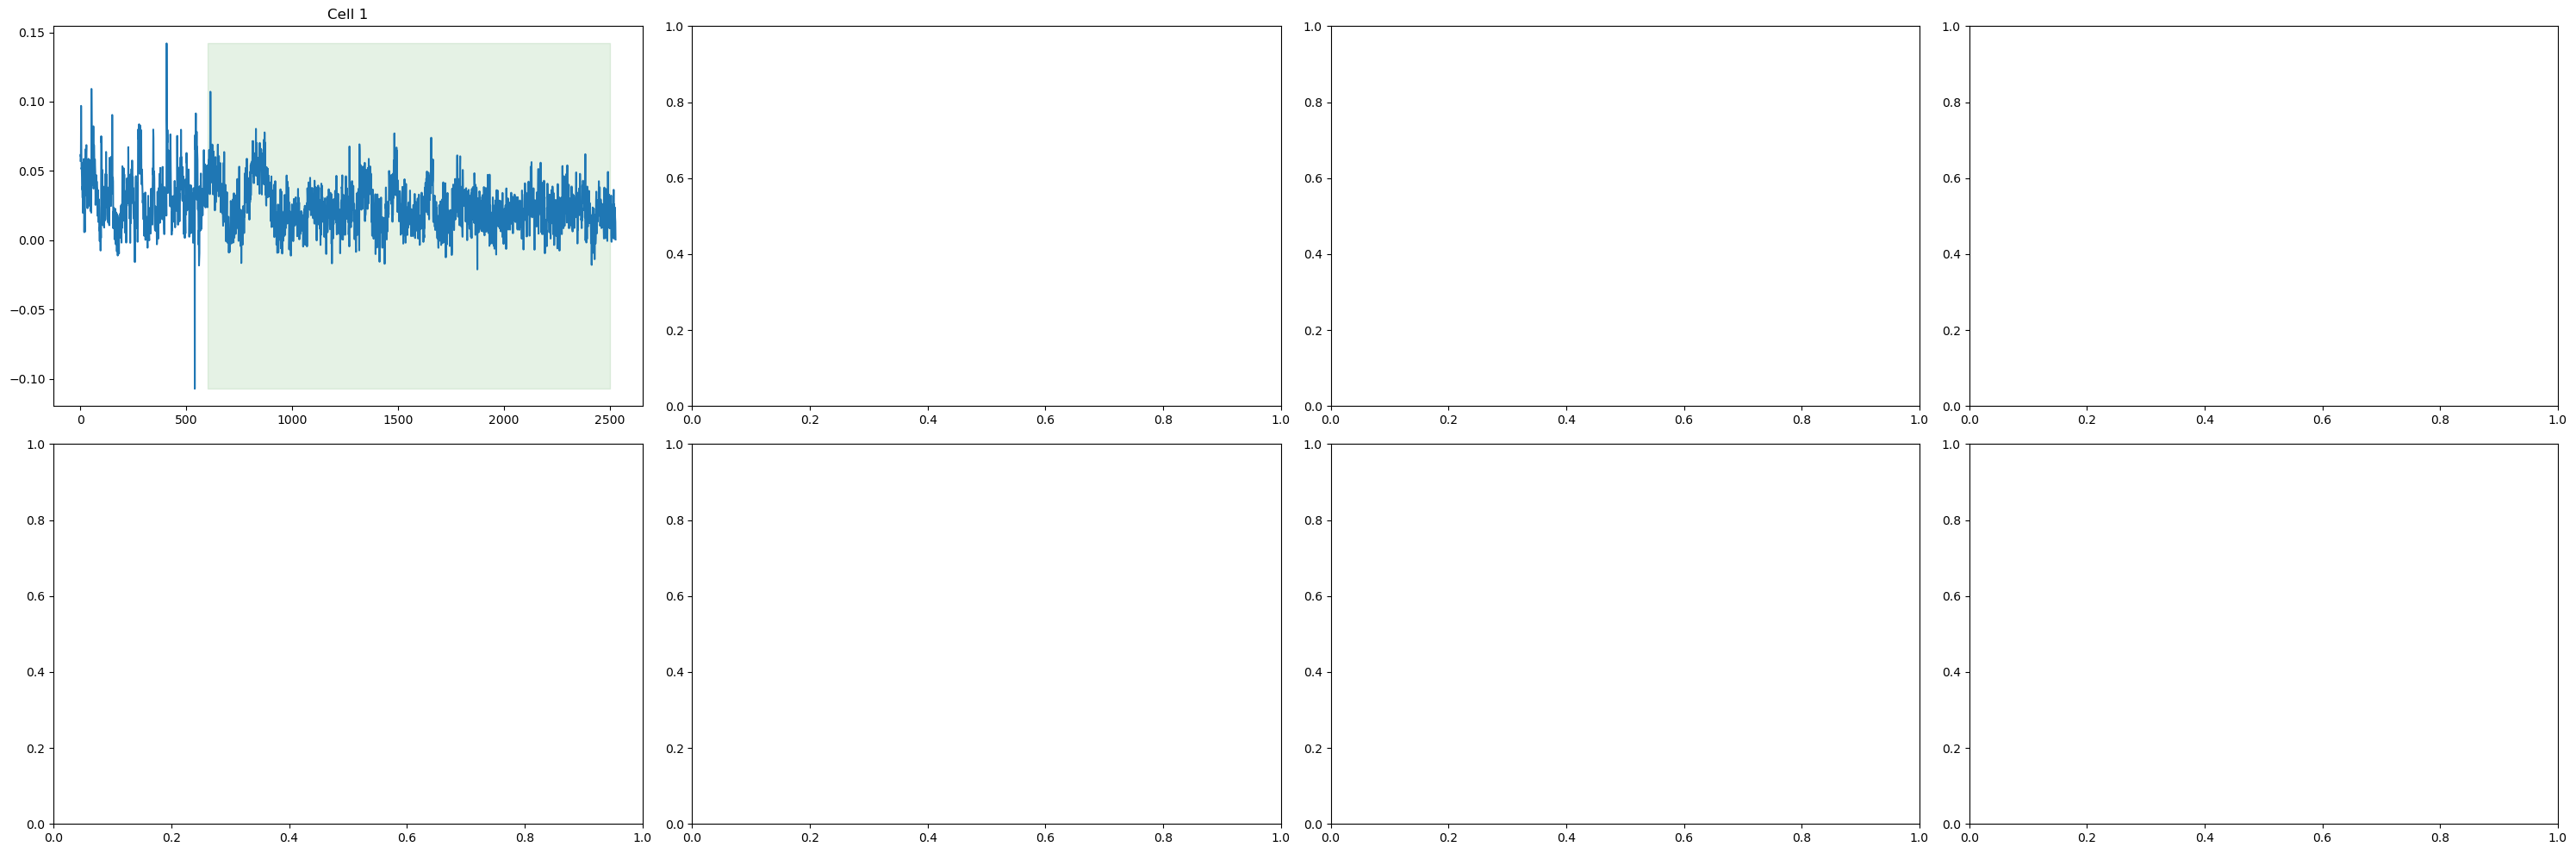

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

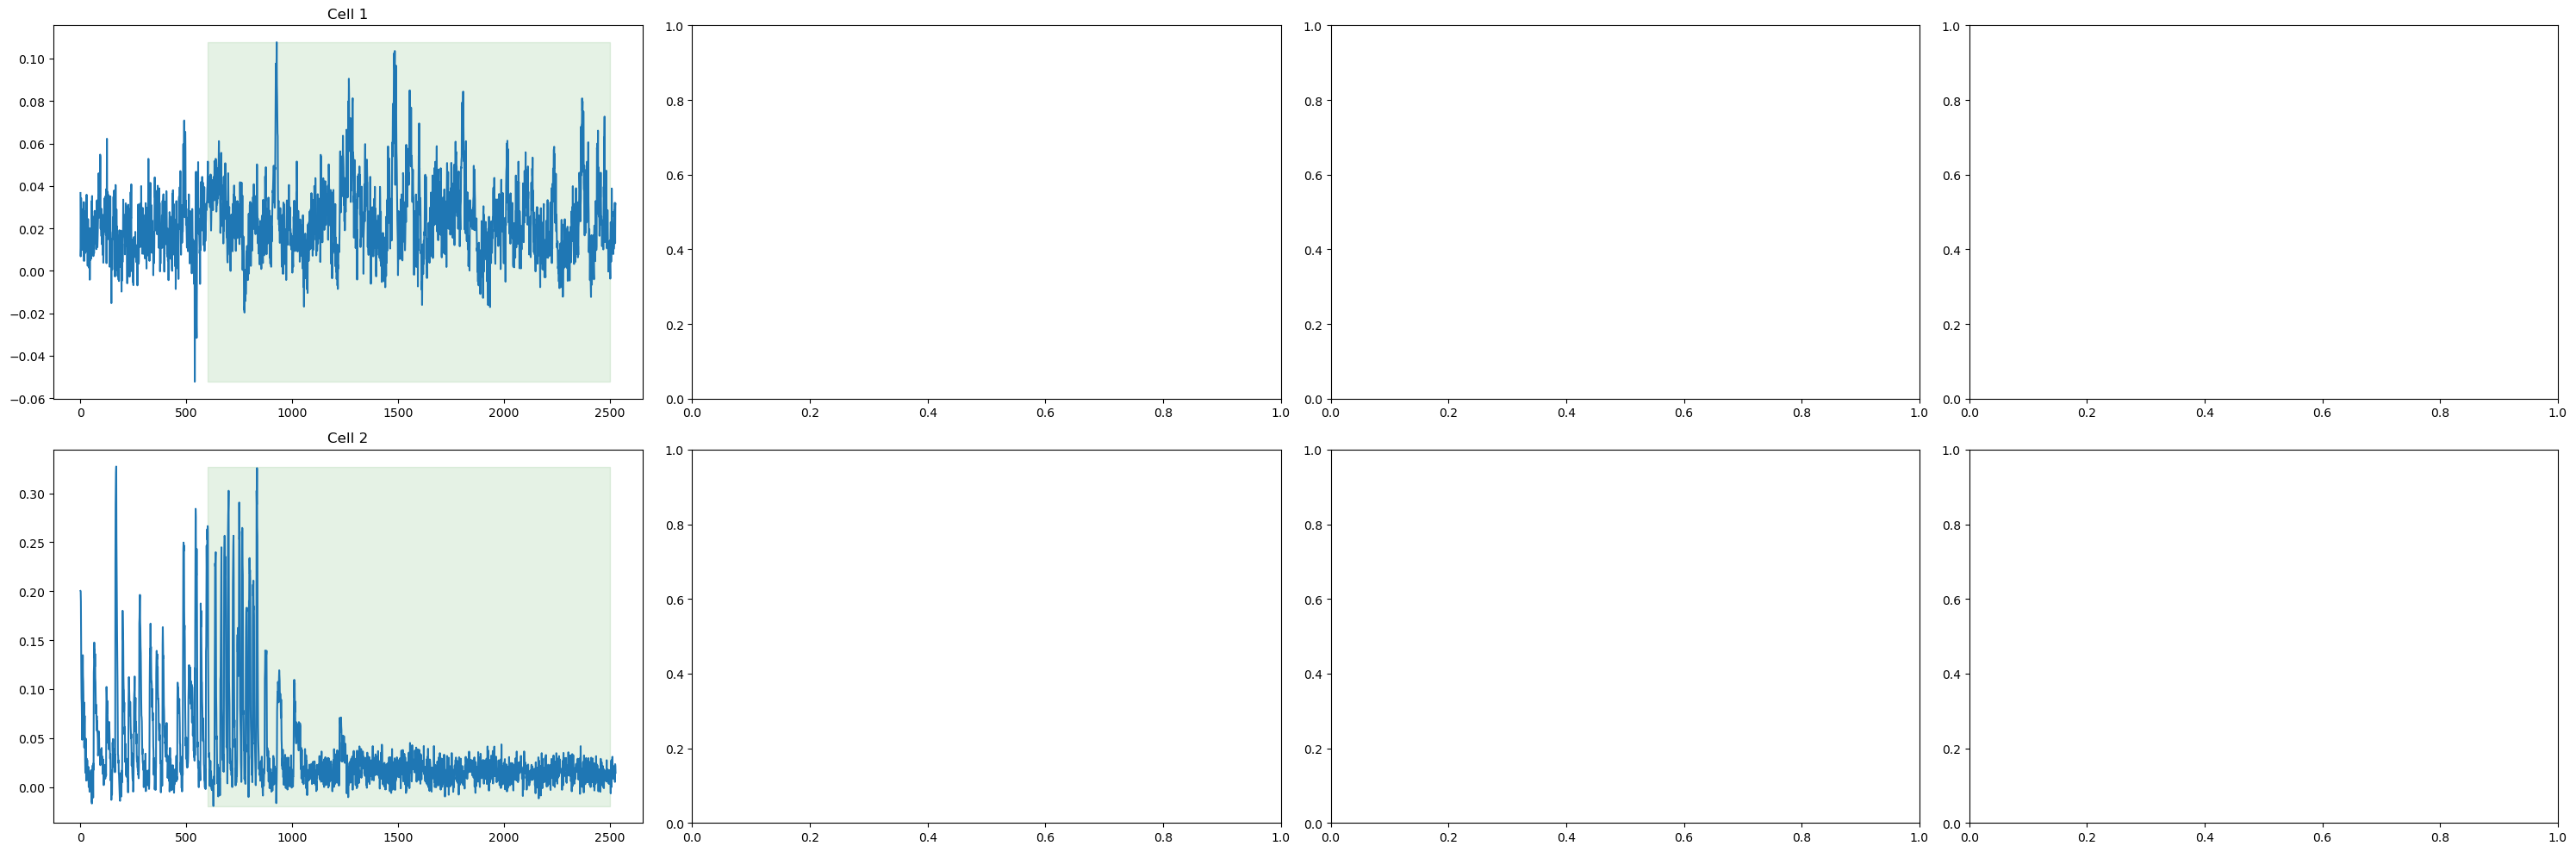

<Figure size 1000x1000 with 0 Axes>

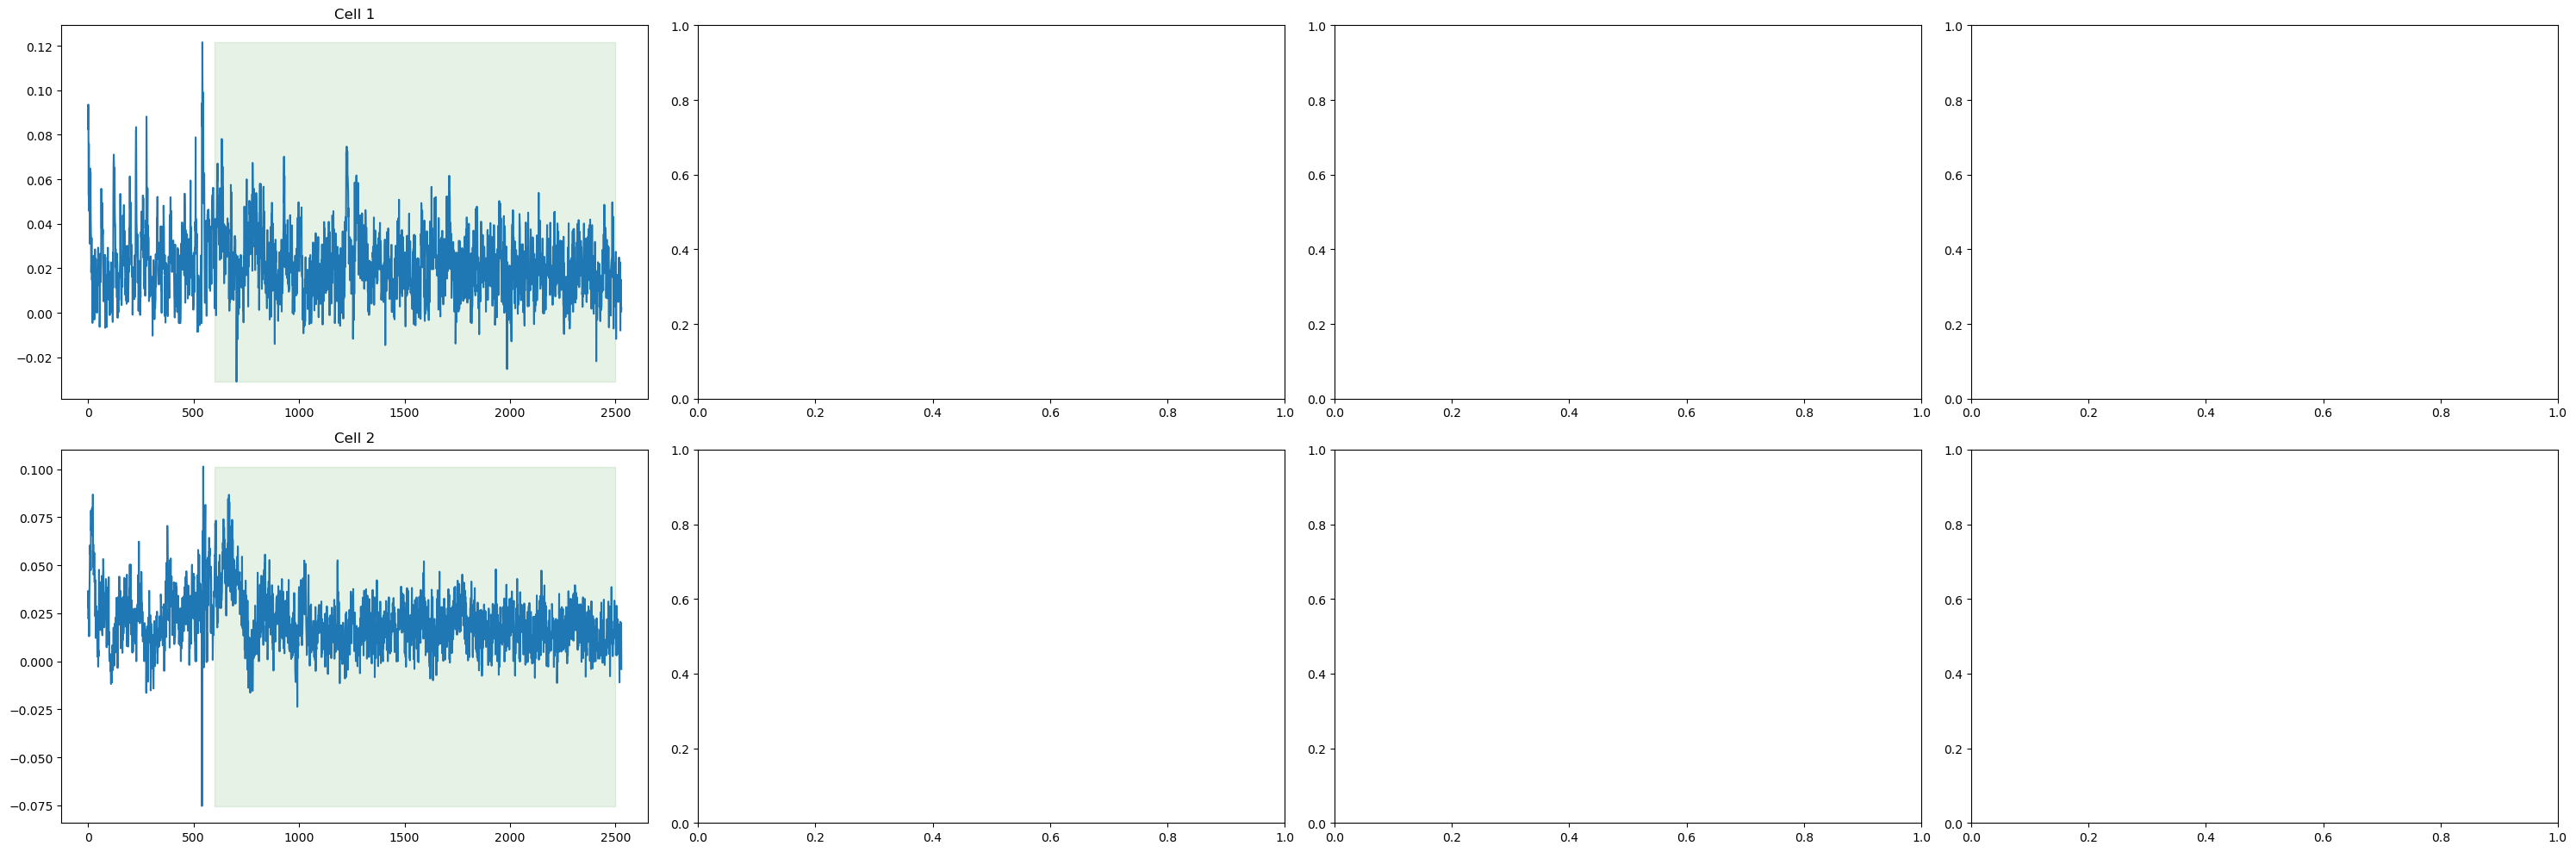

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

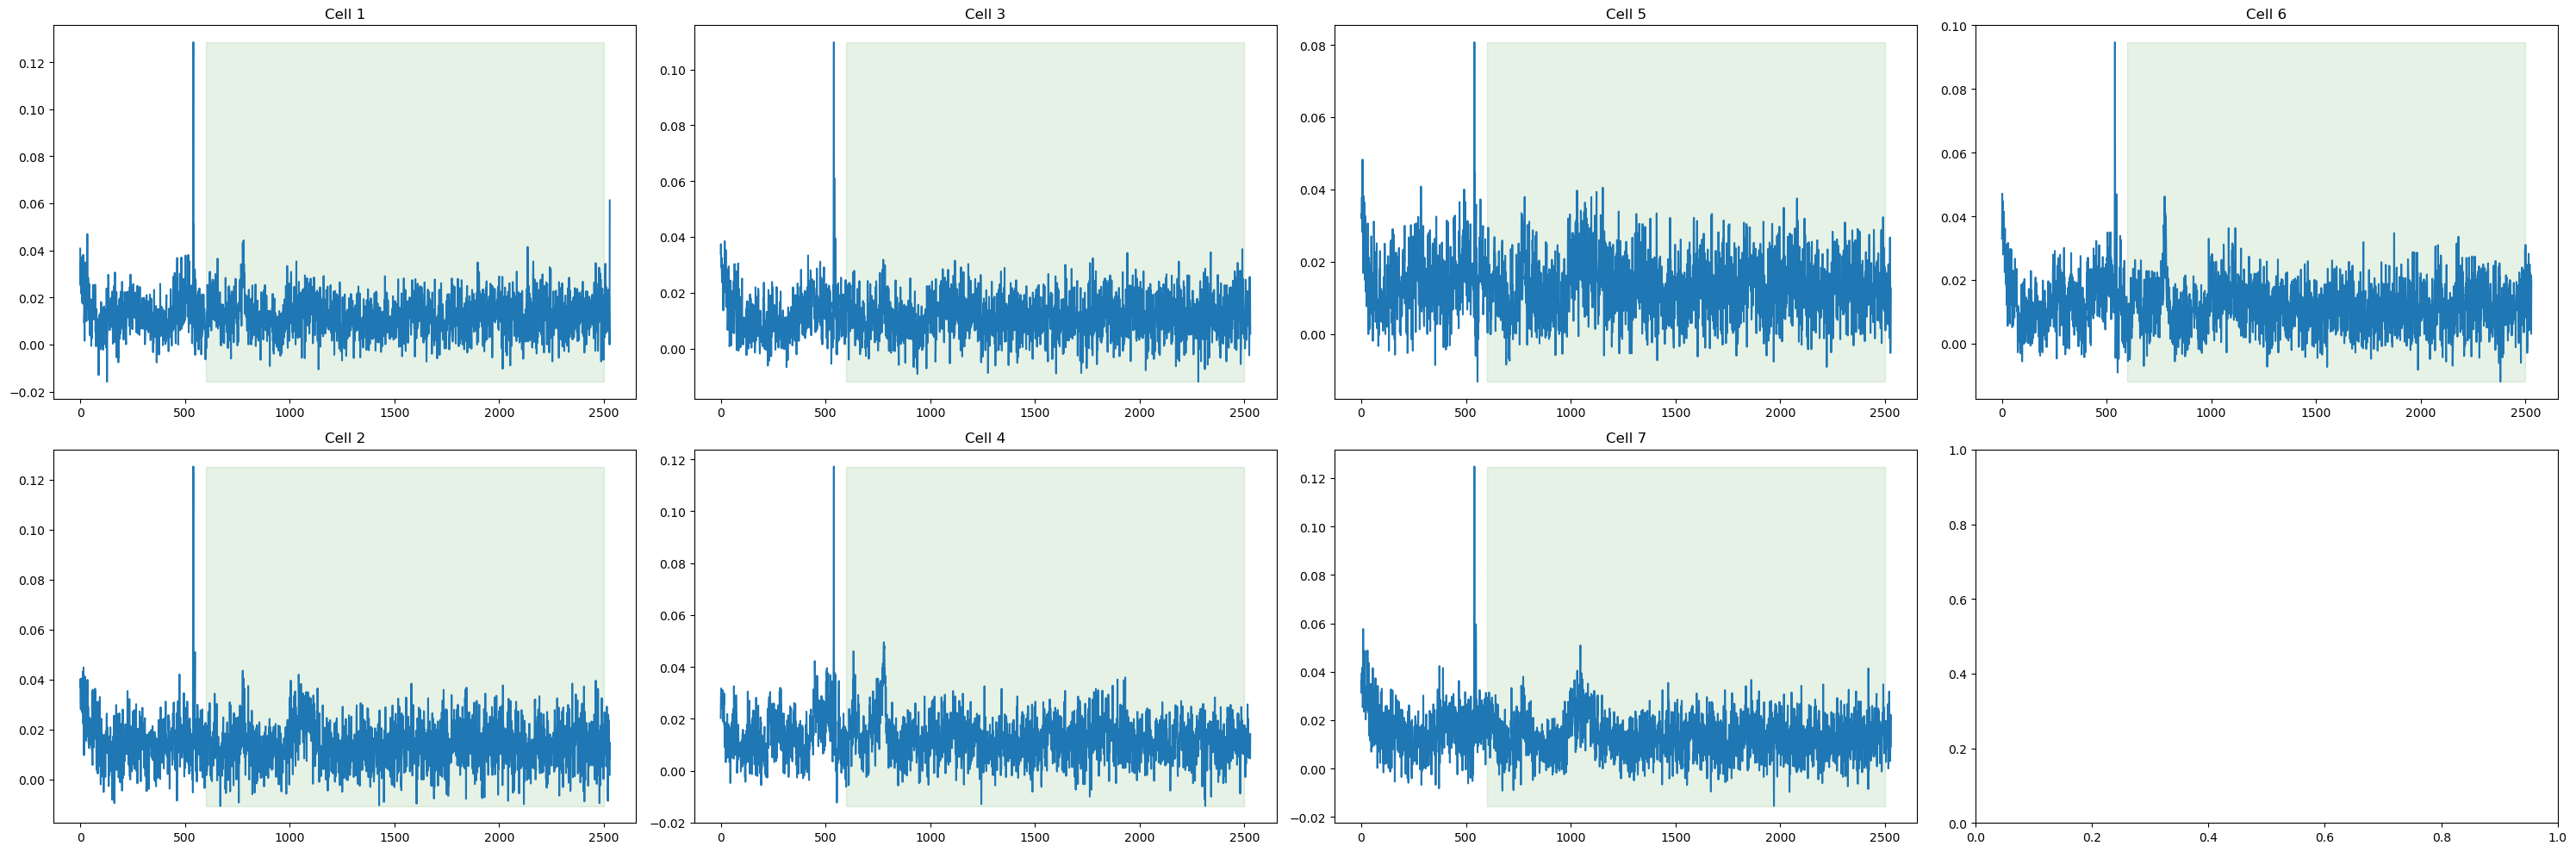

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

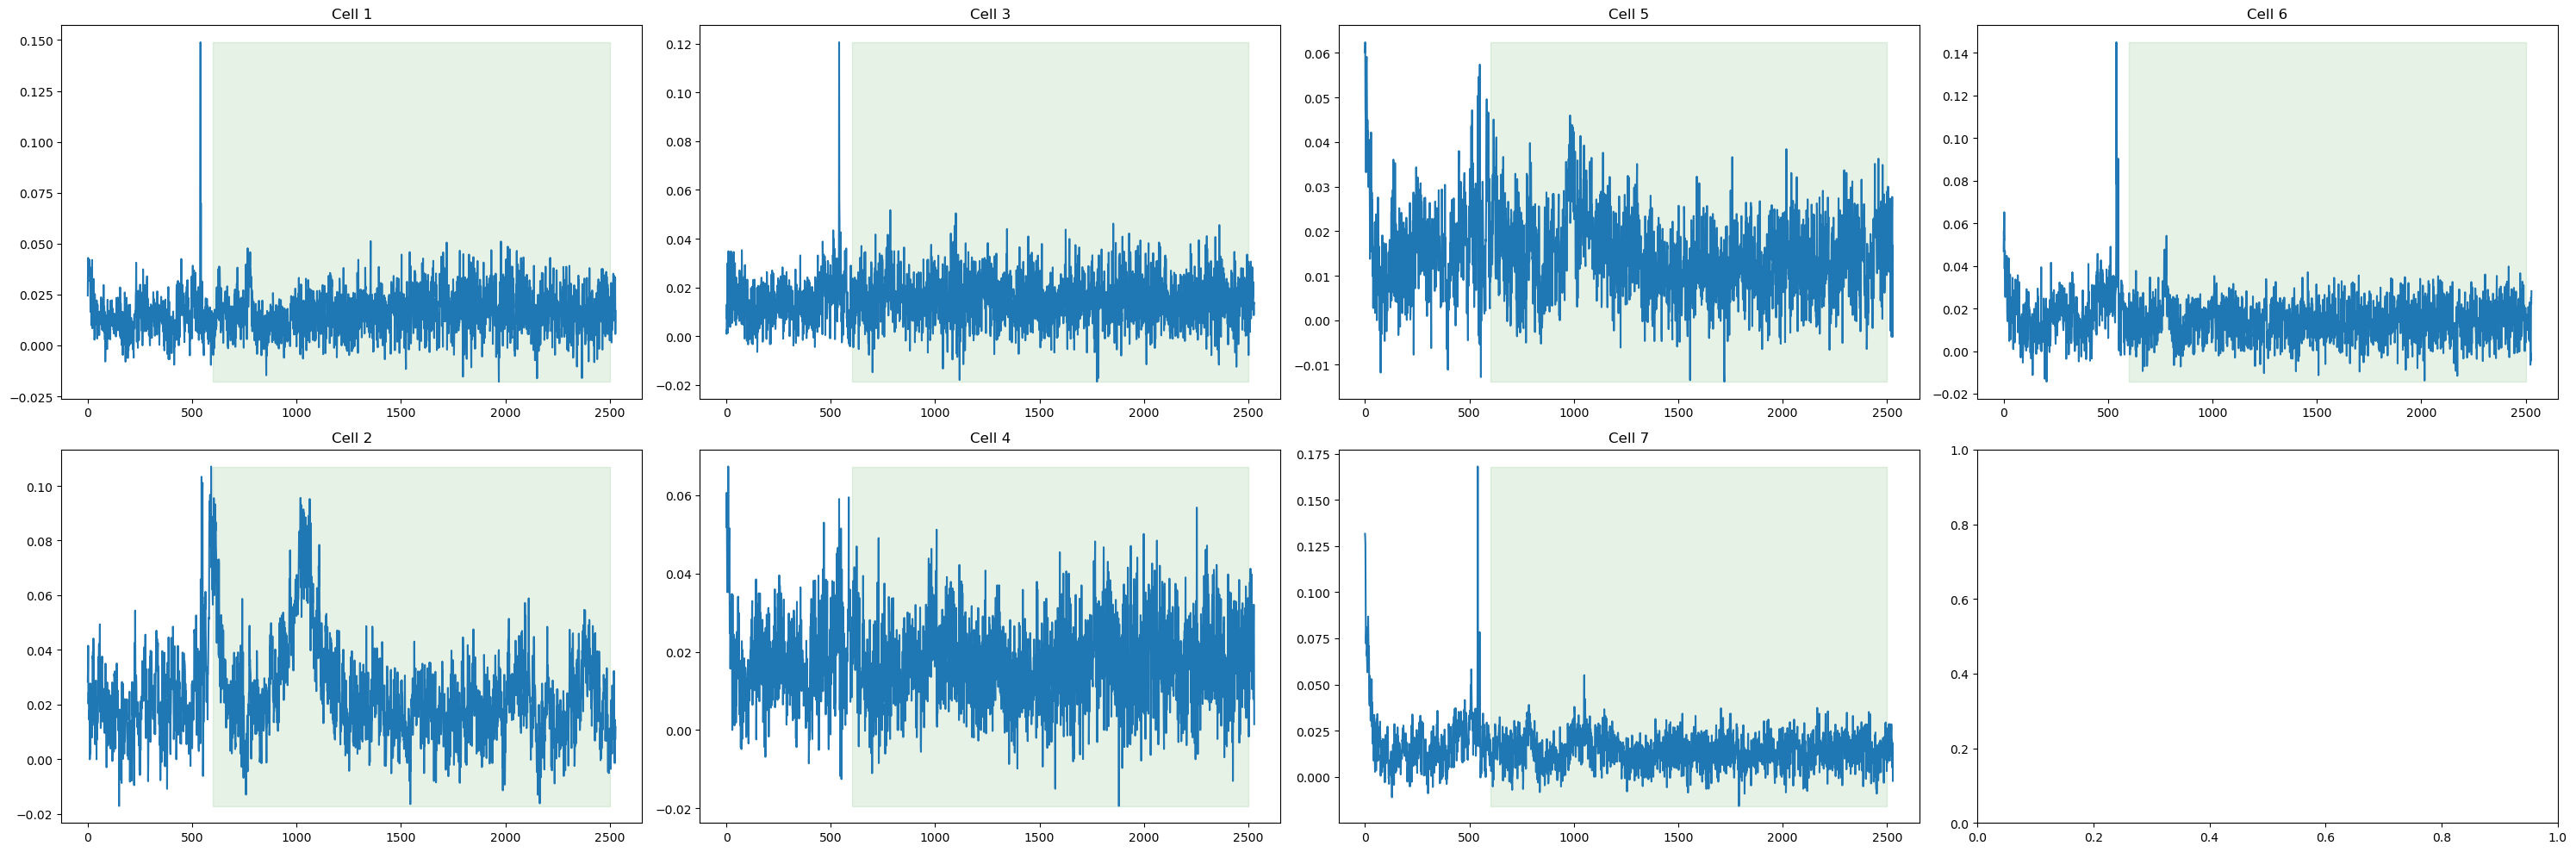

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

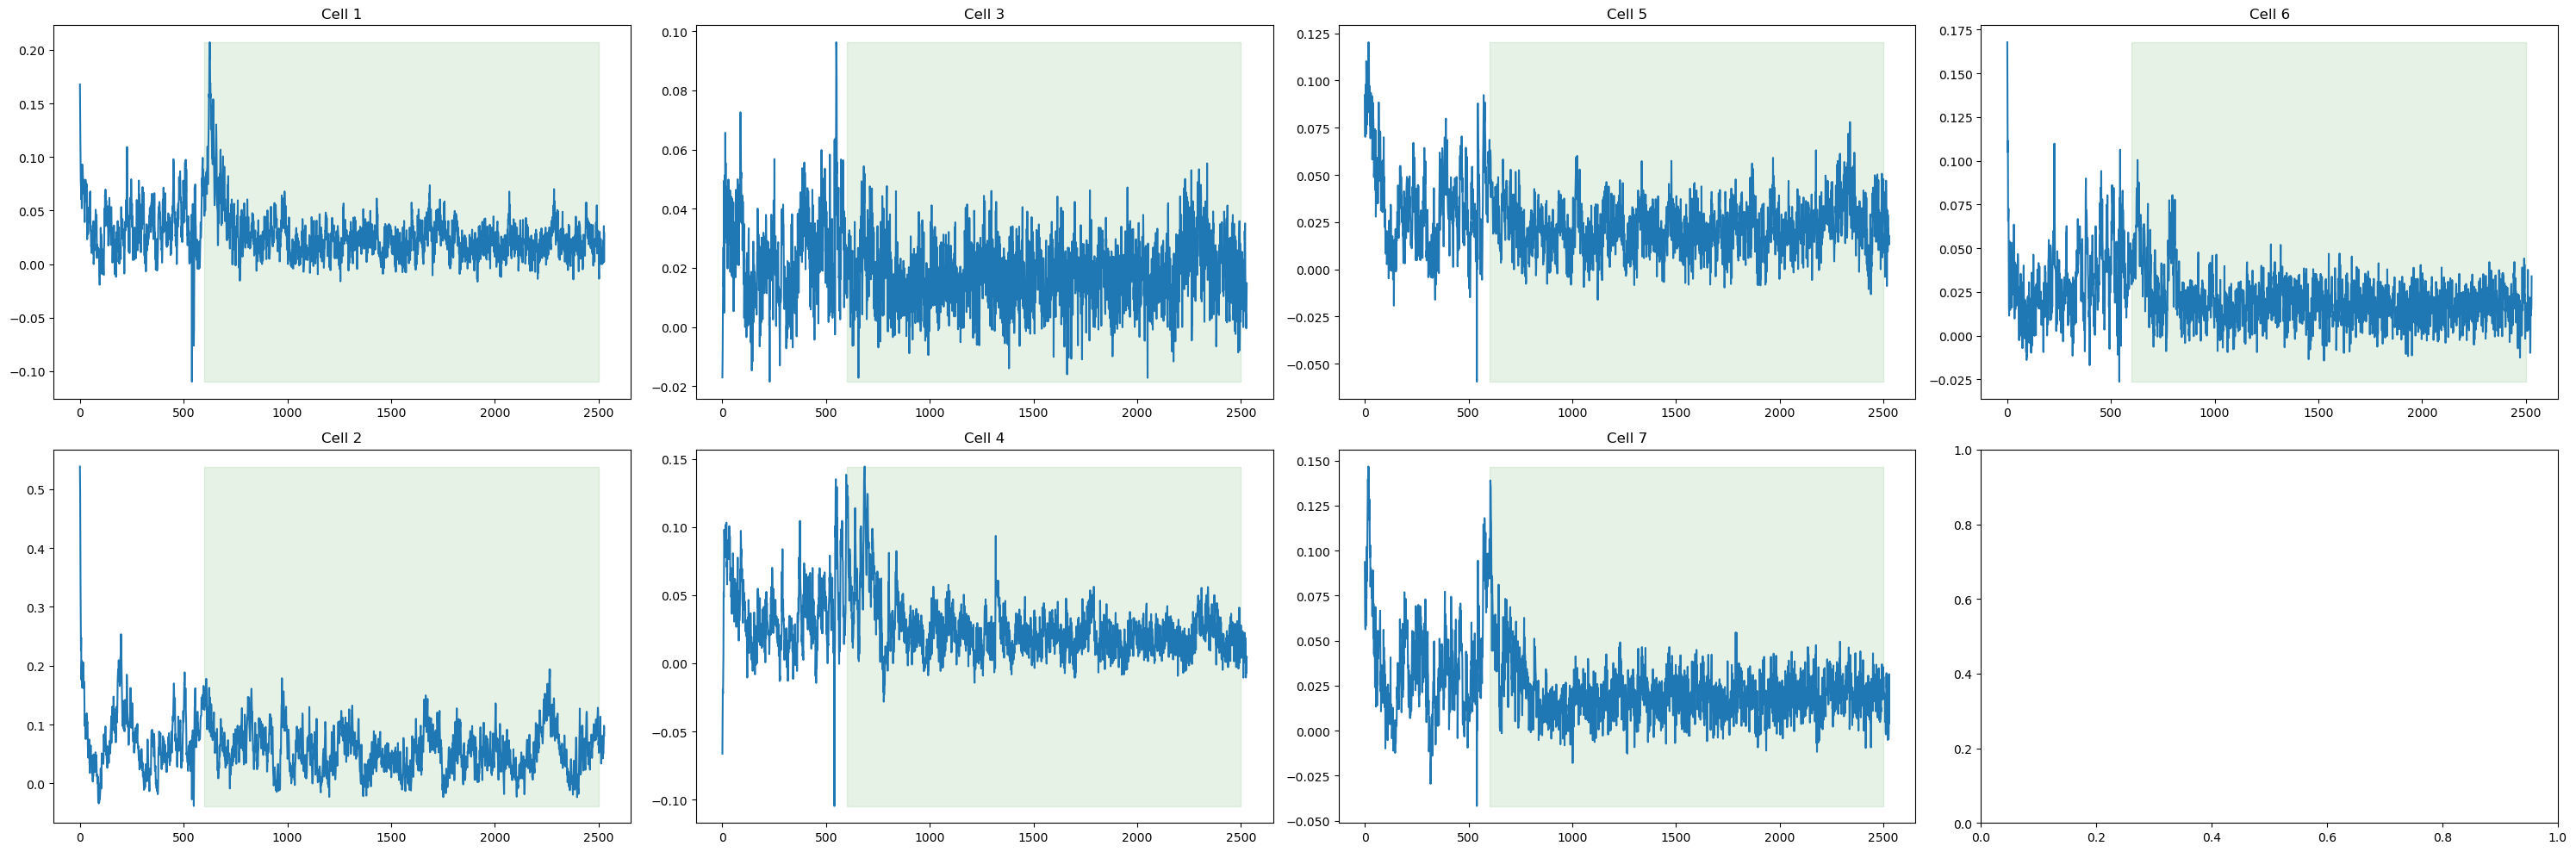

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

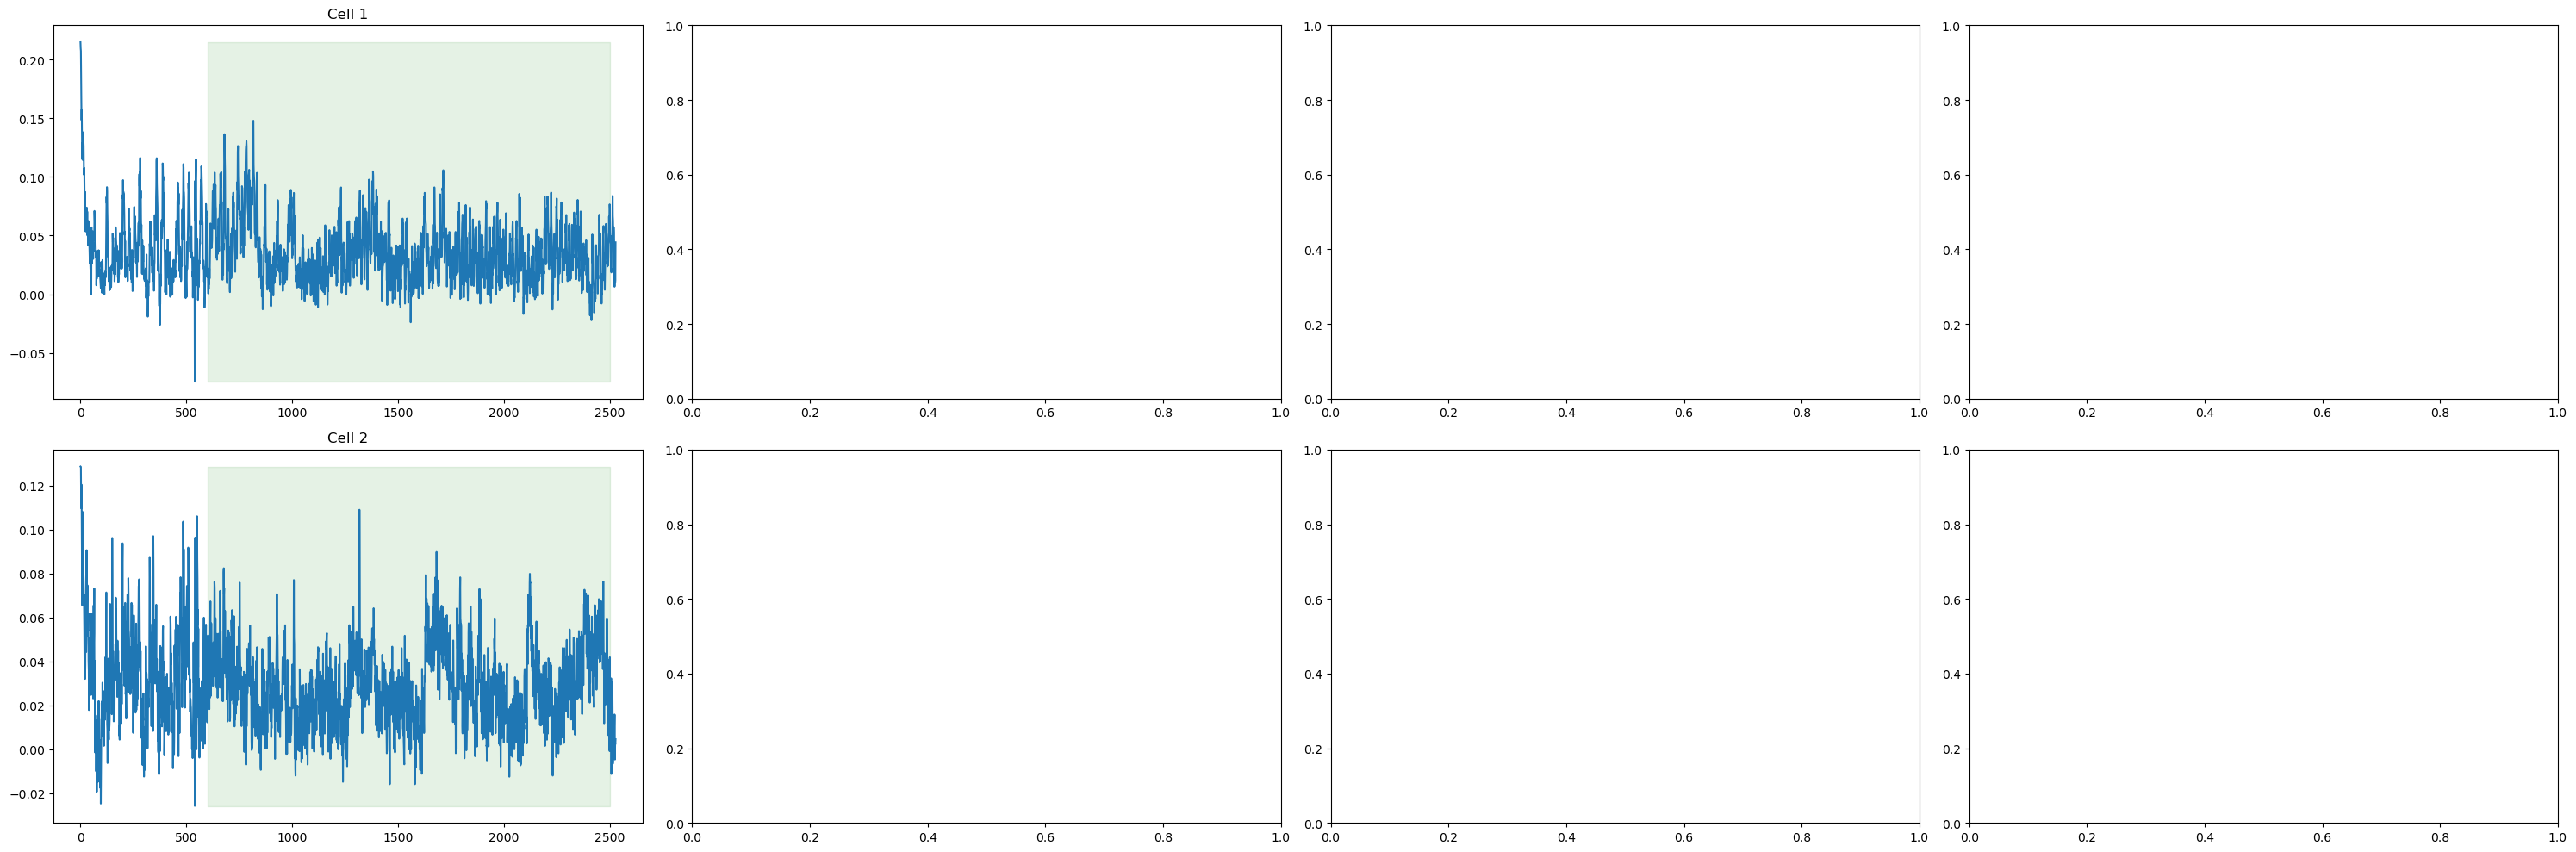

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

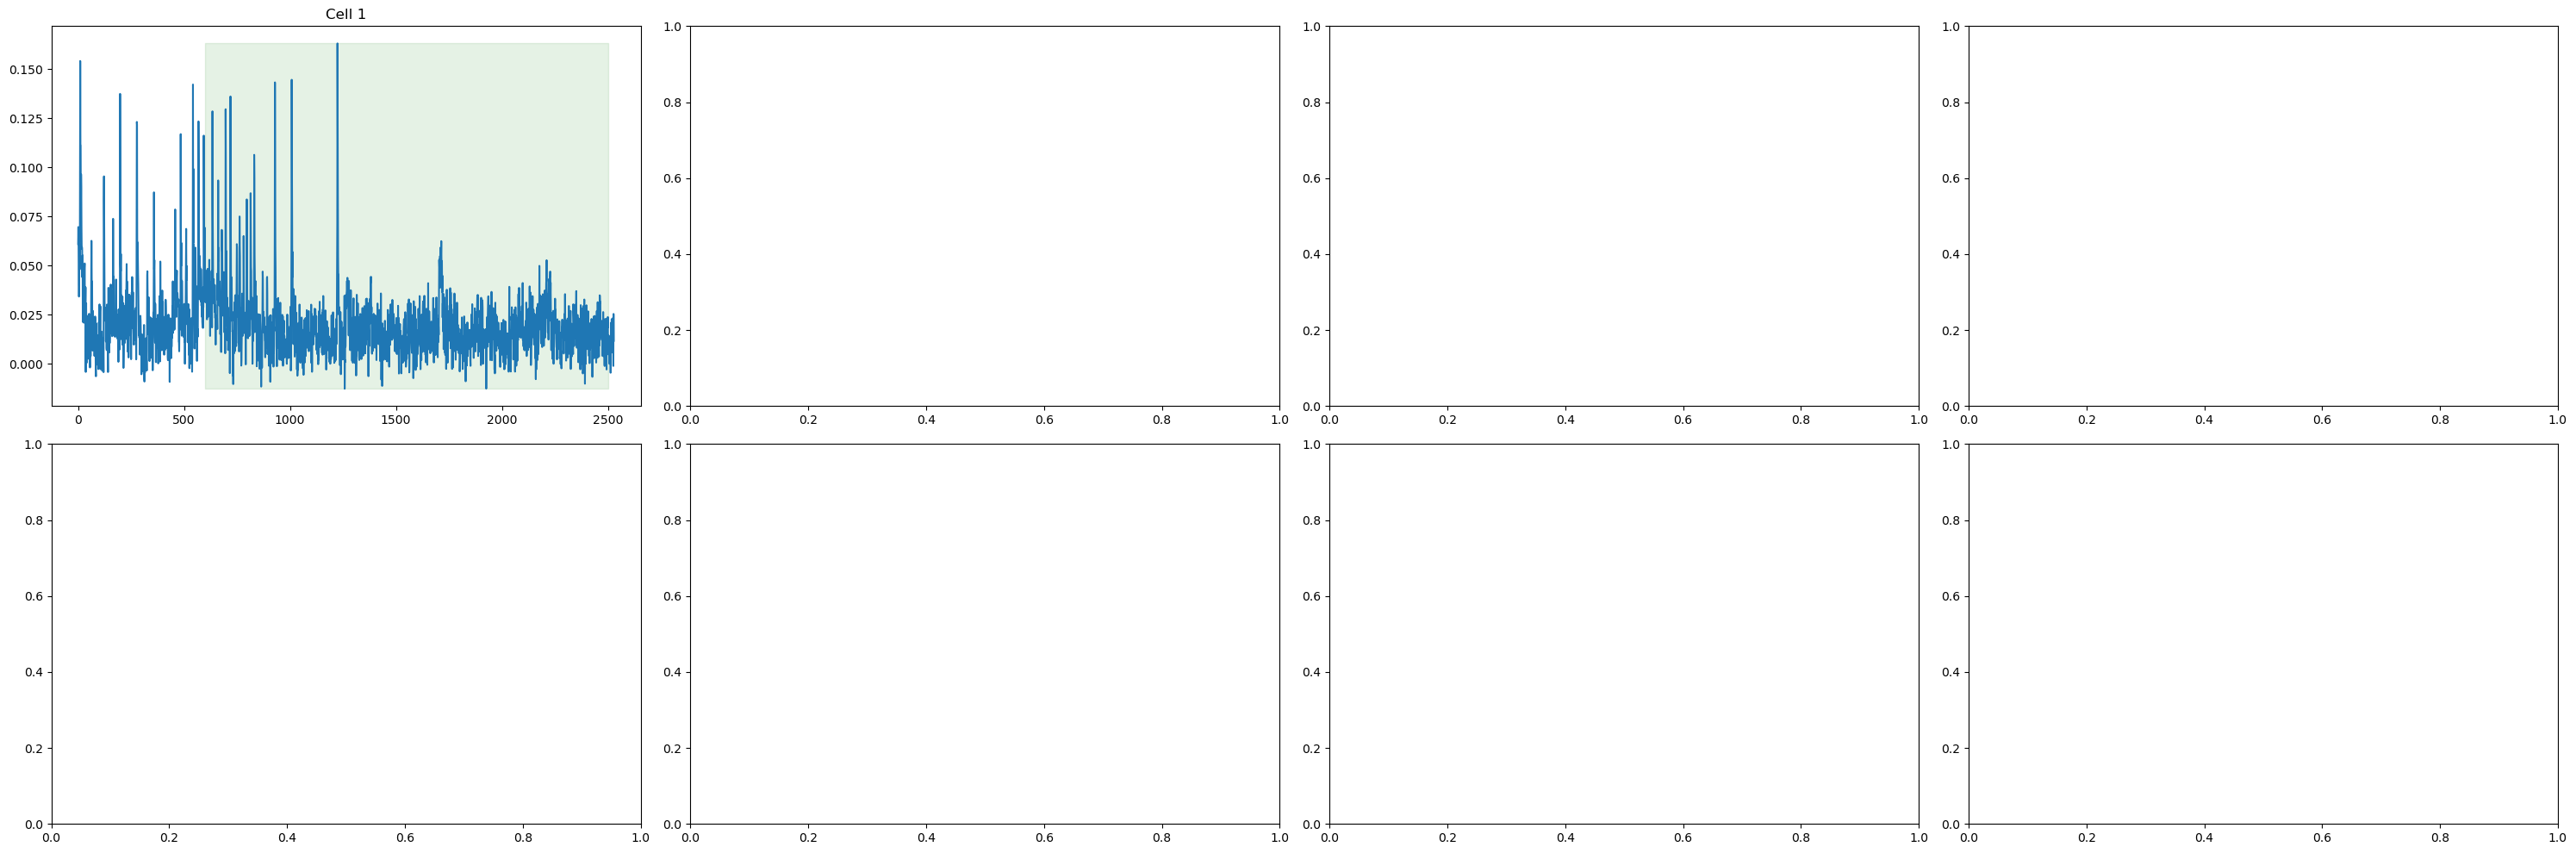

<Figure size 1000x1000 with 0 Axes>

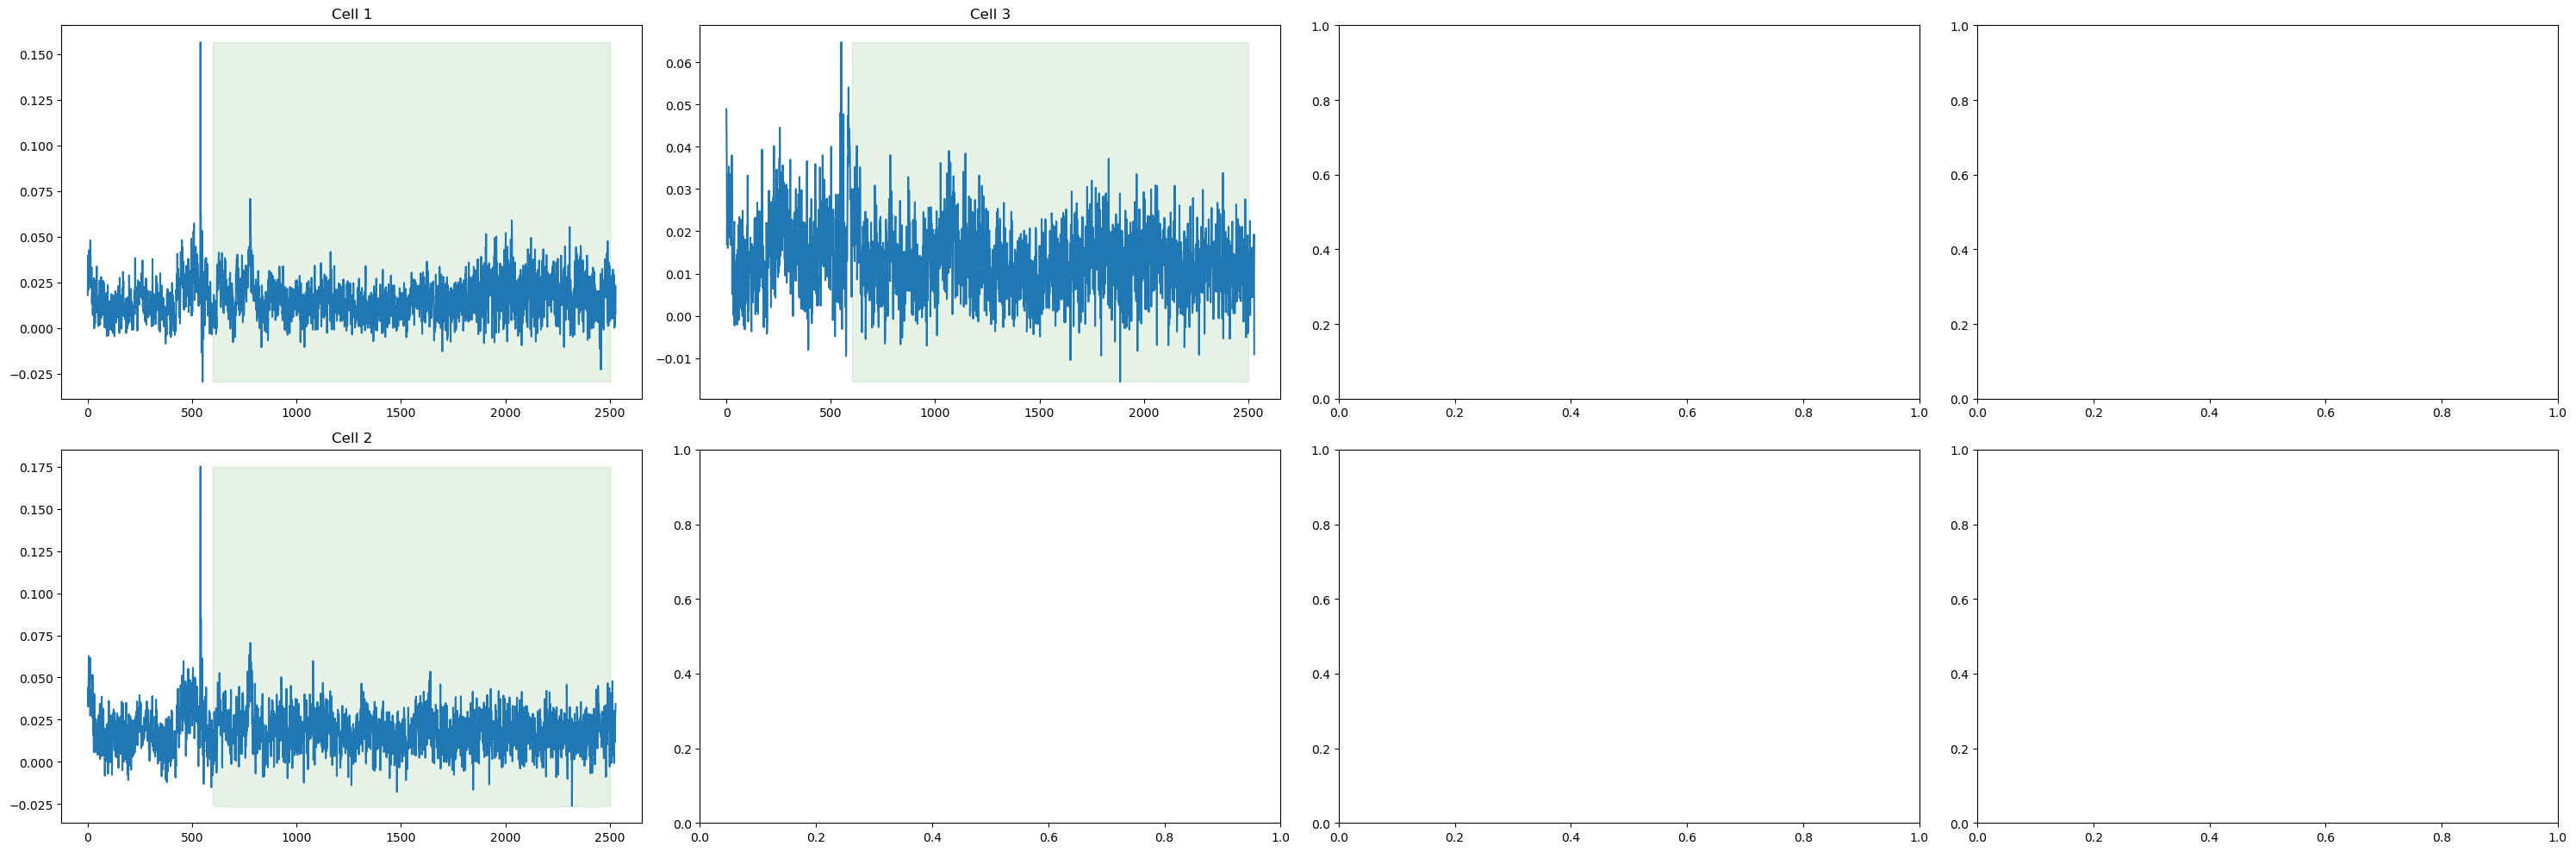

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

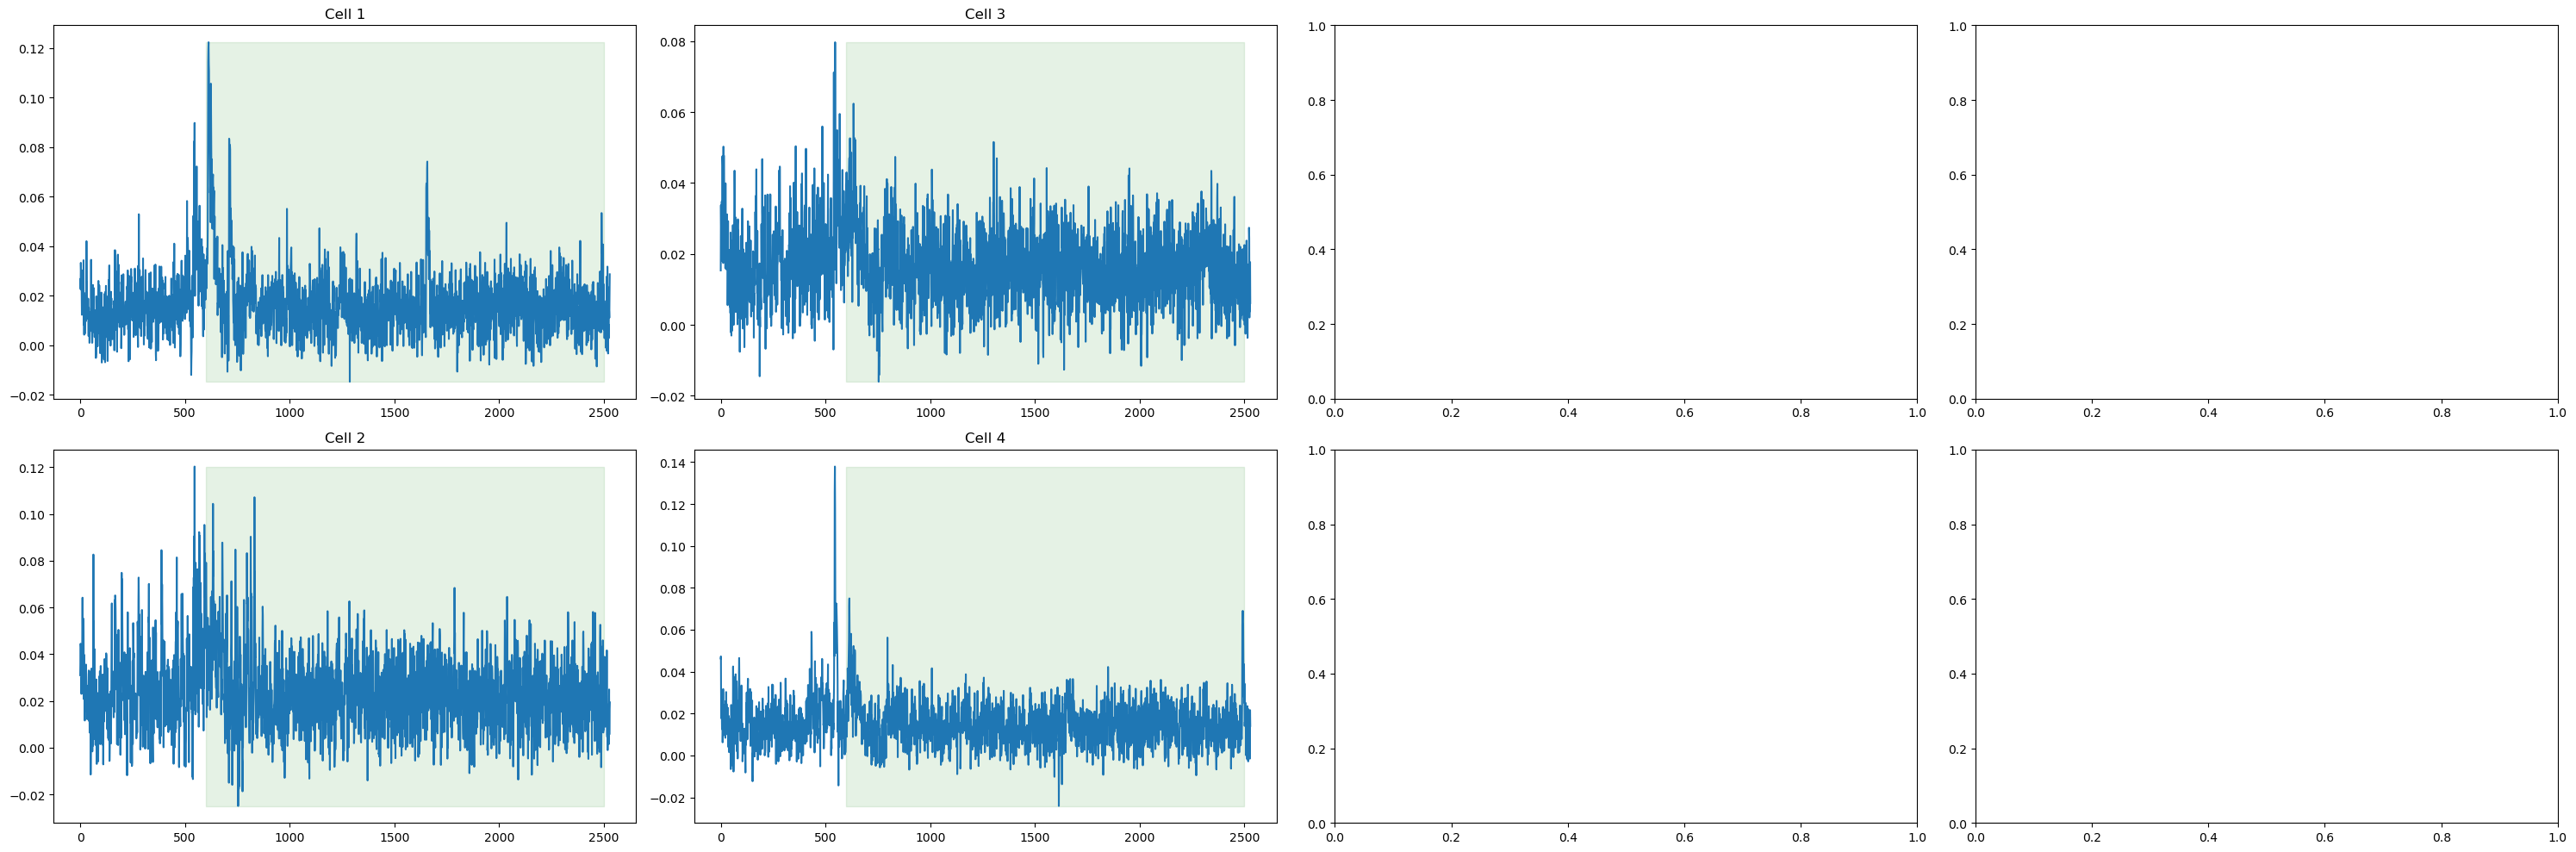

<Figure size 1000x1000 with 0 Axes>

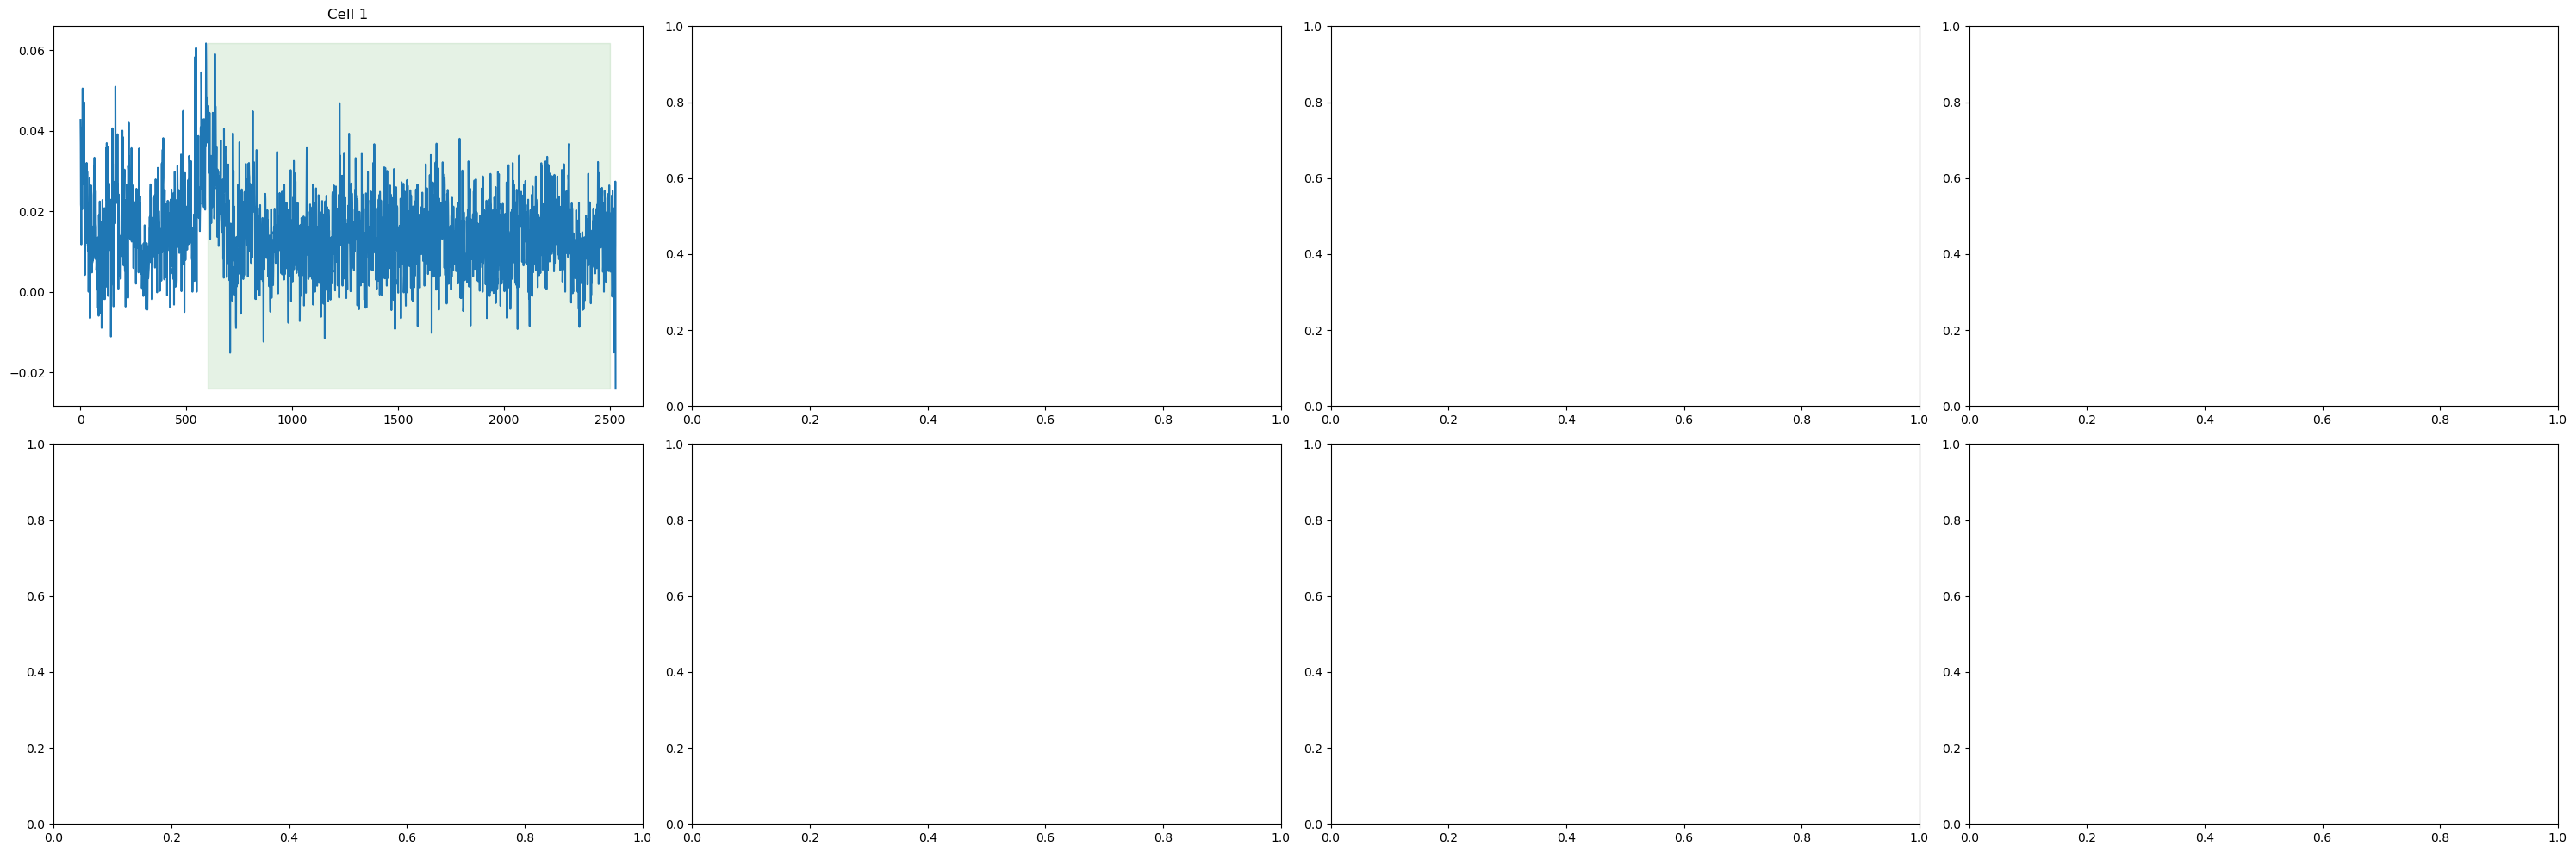

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

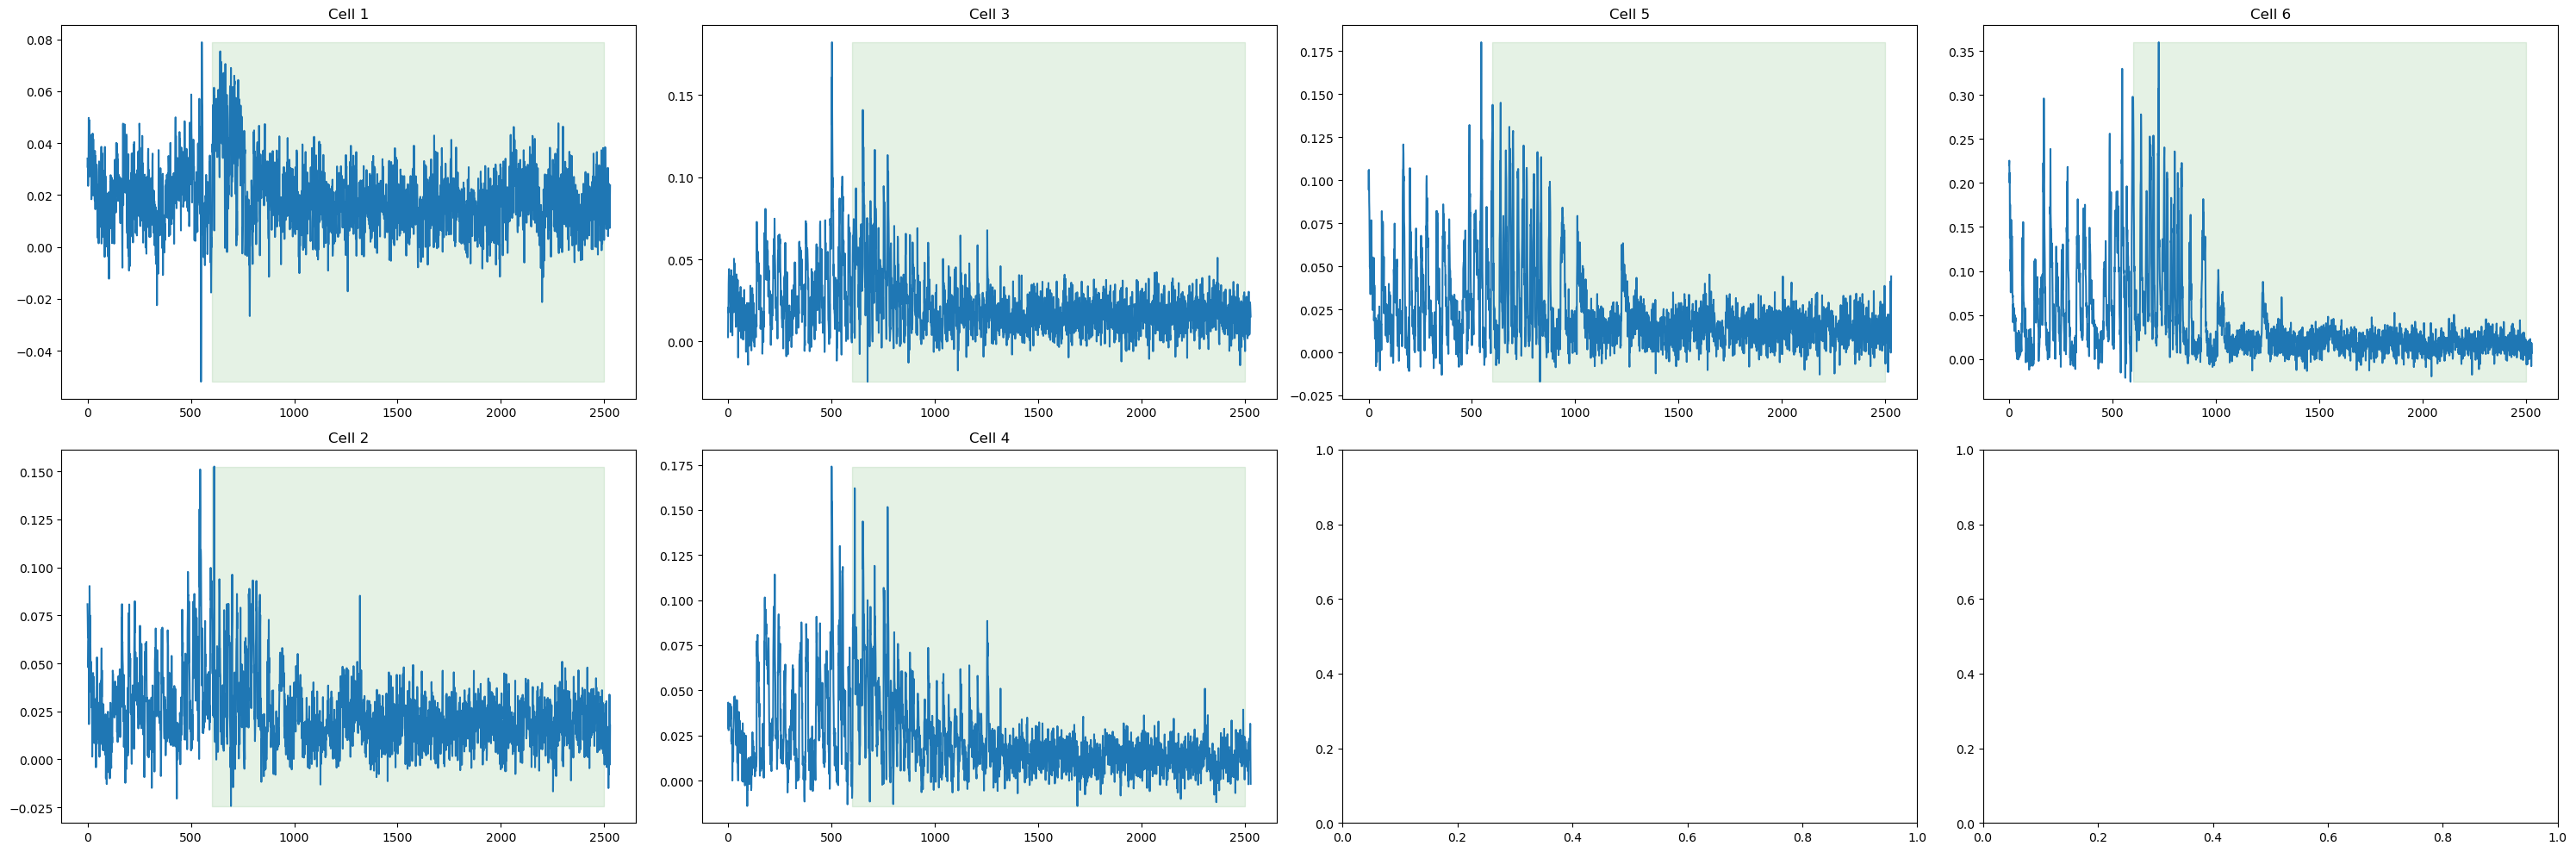

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

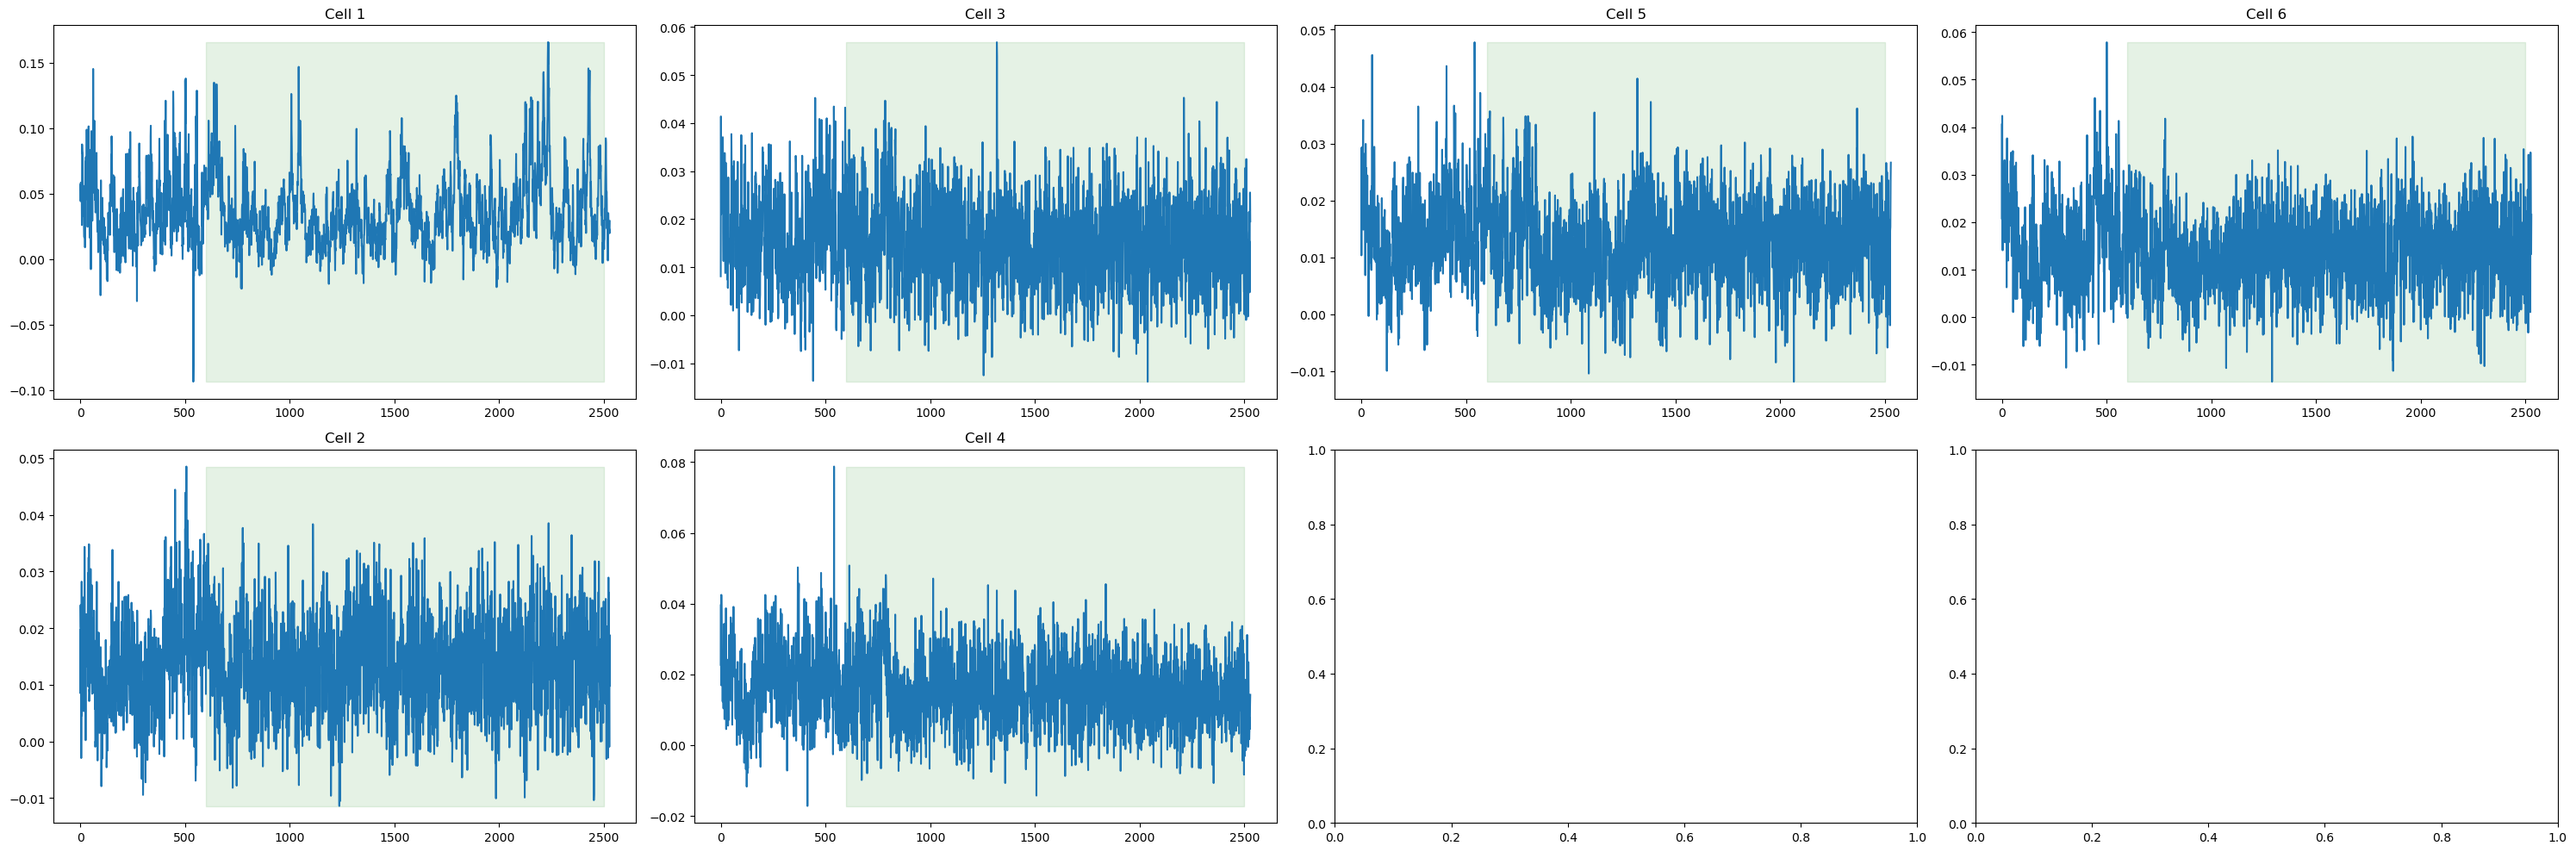

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

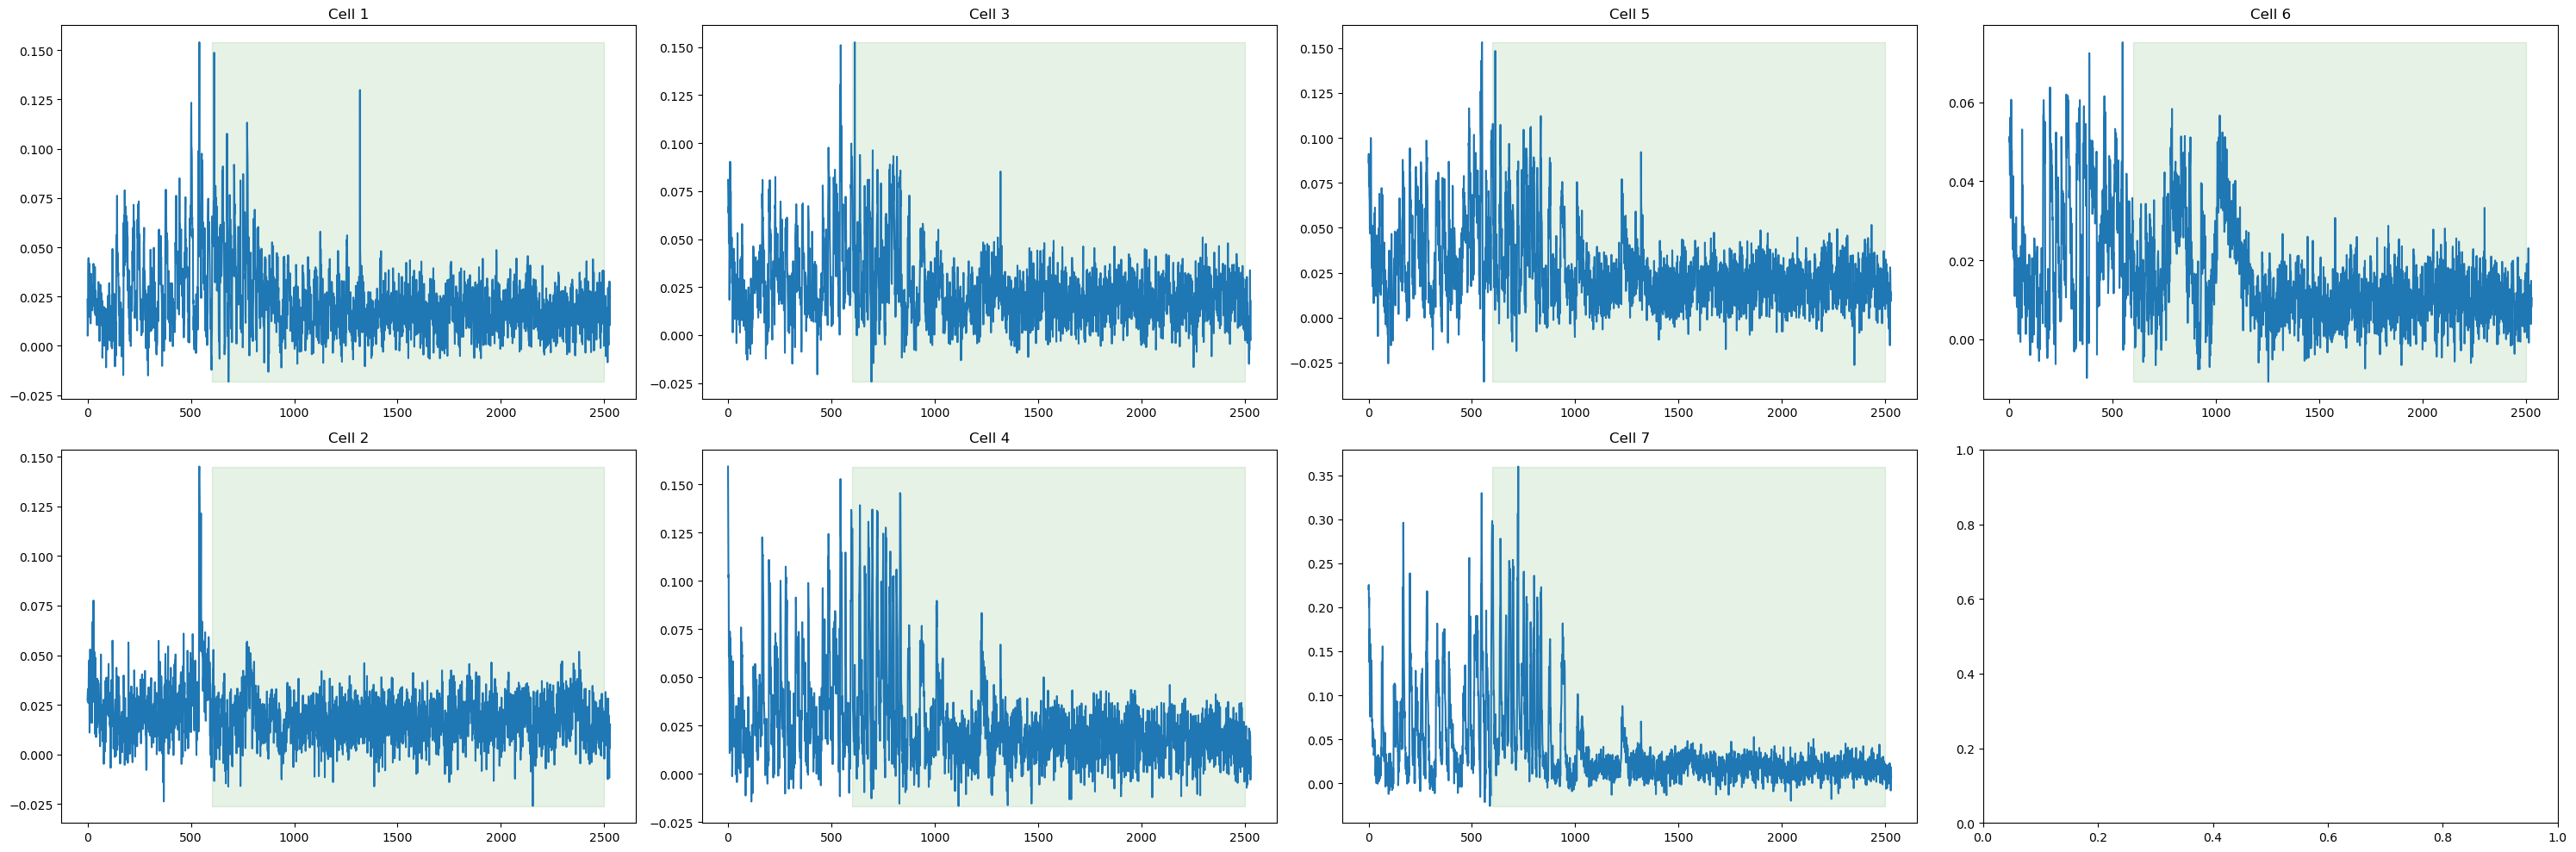

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

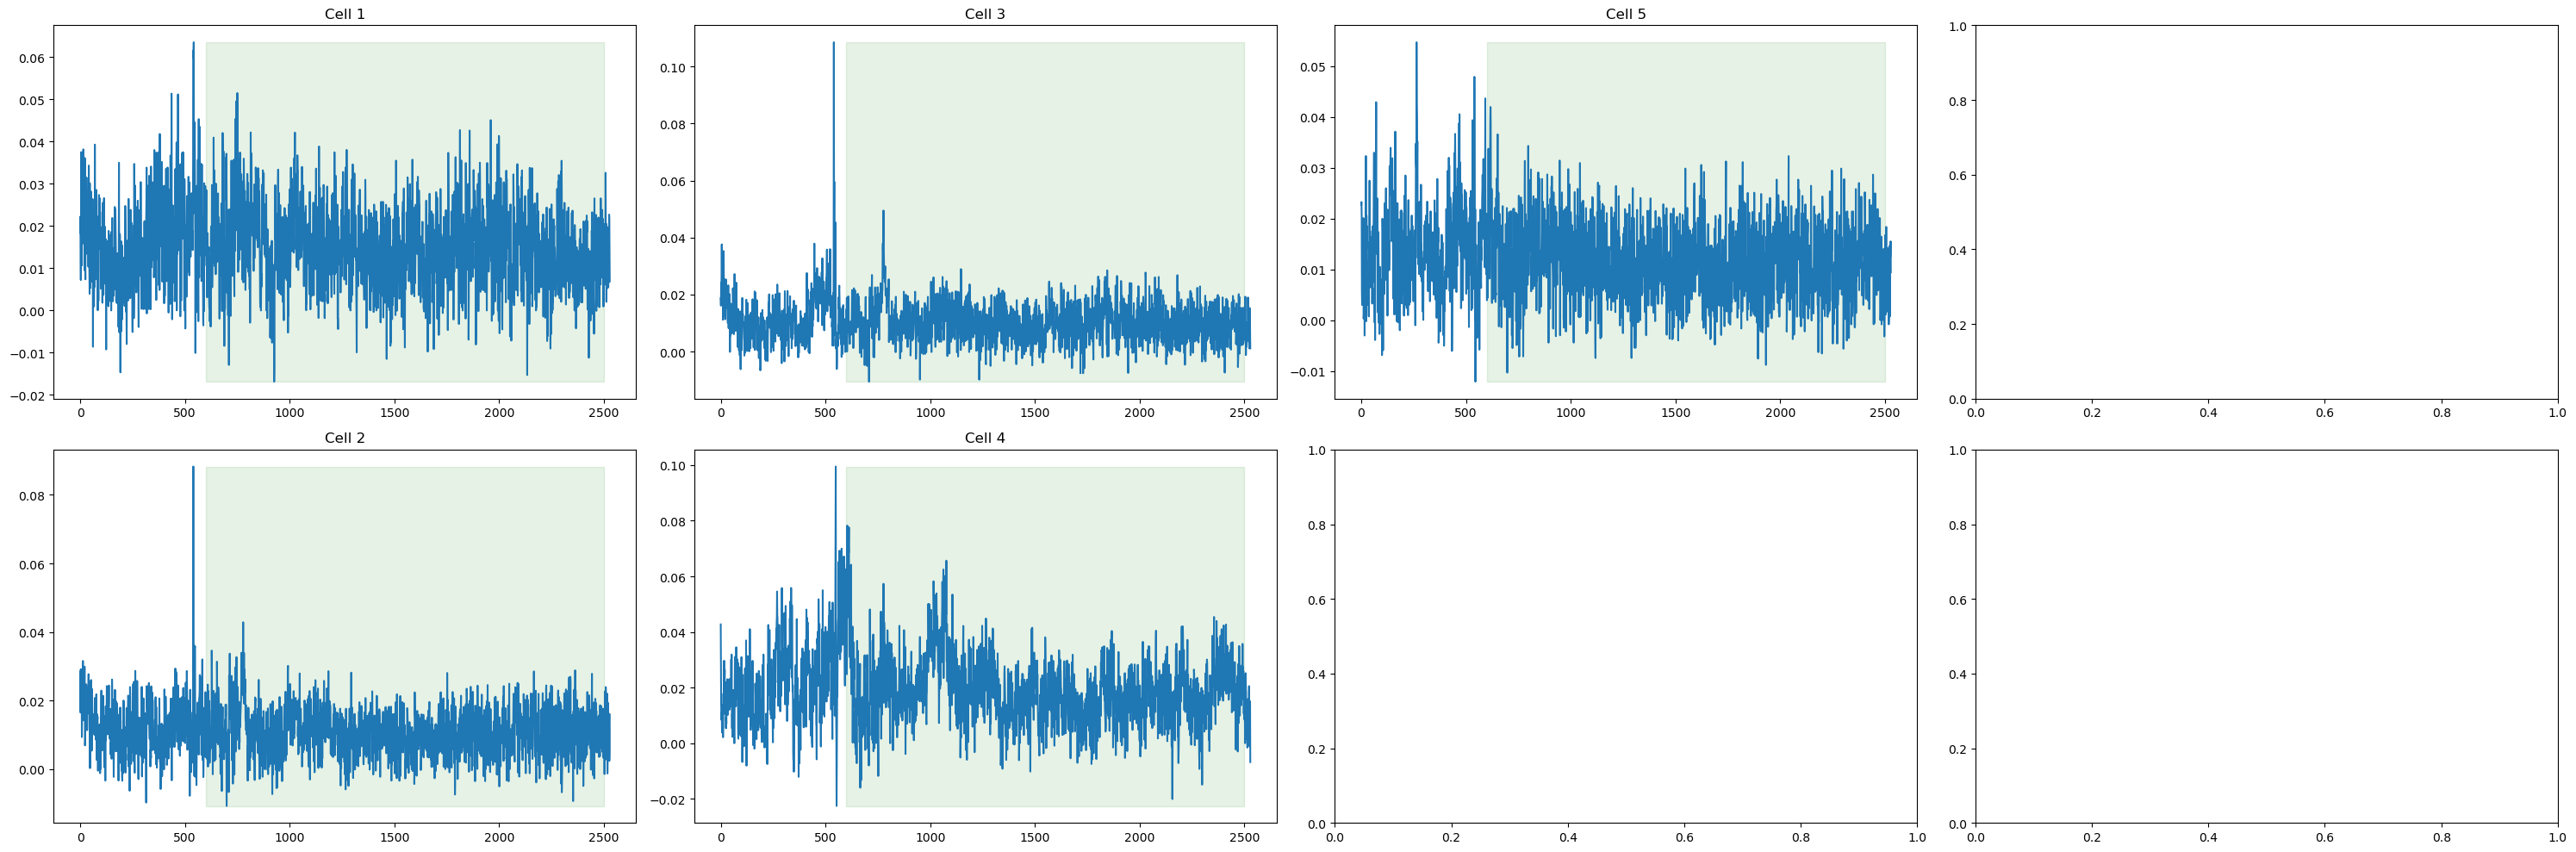

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

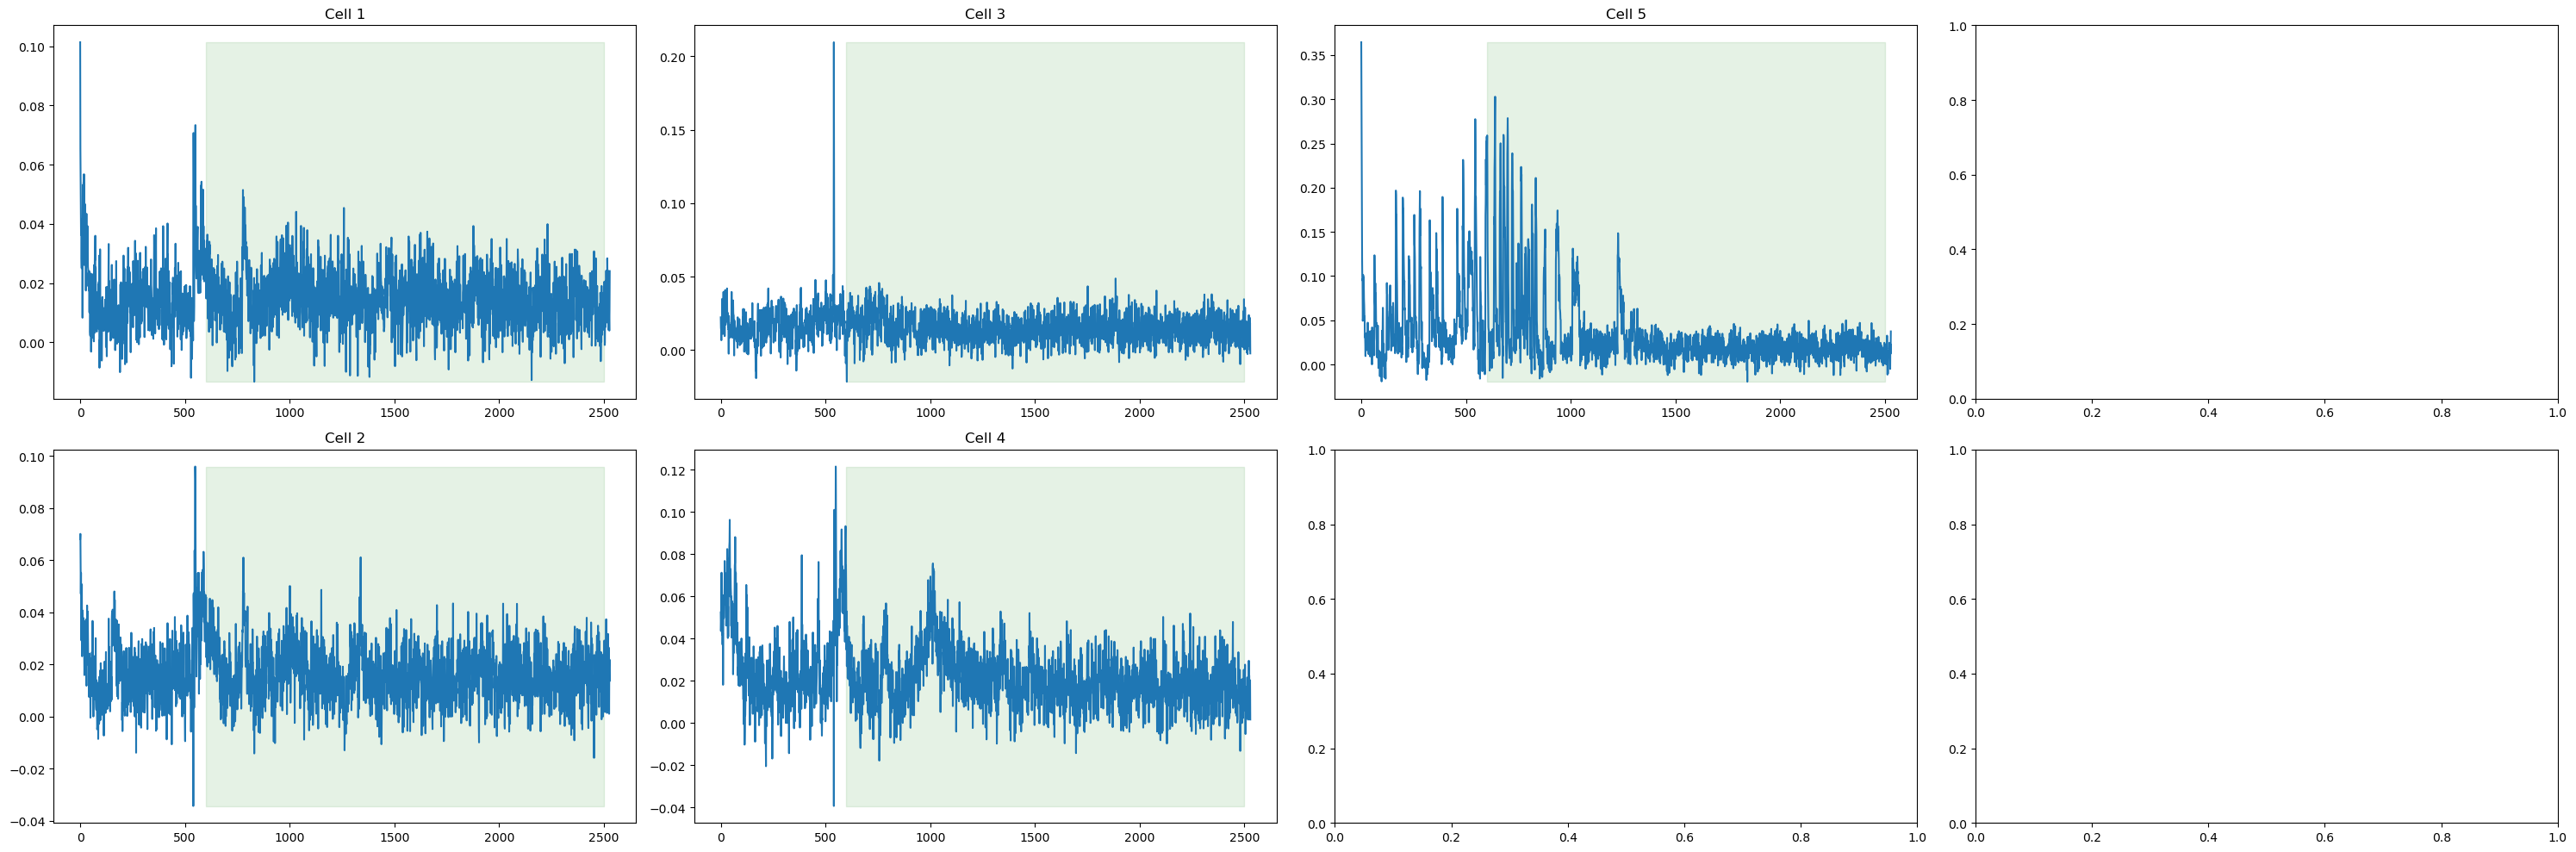

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

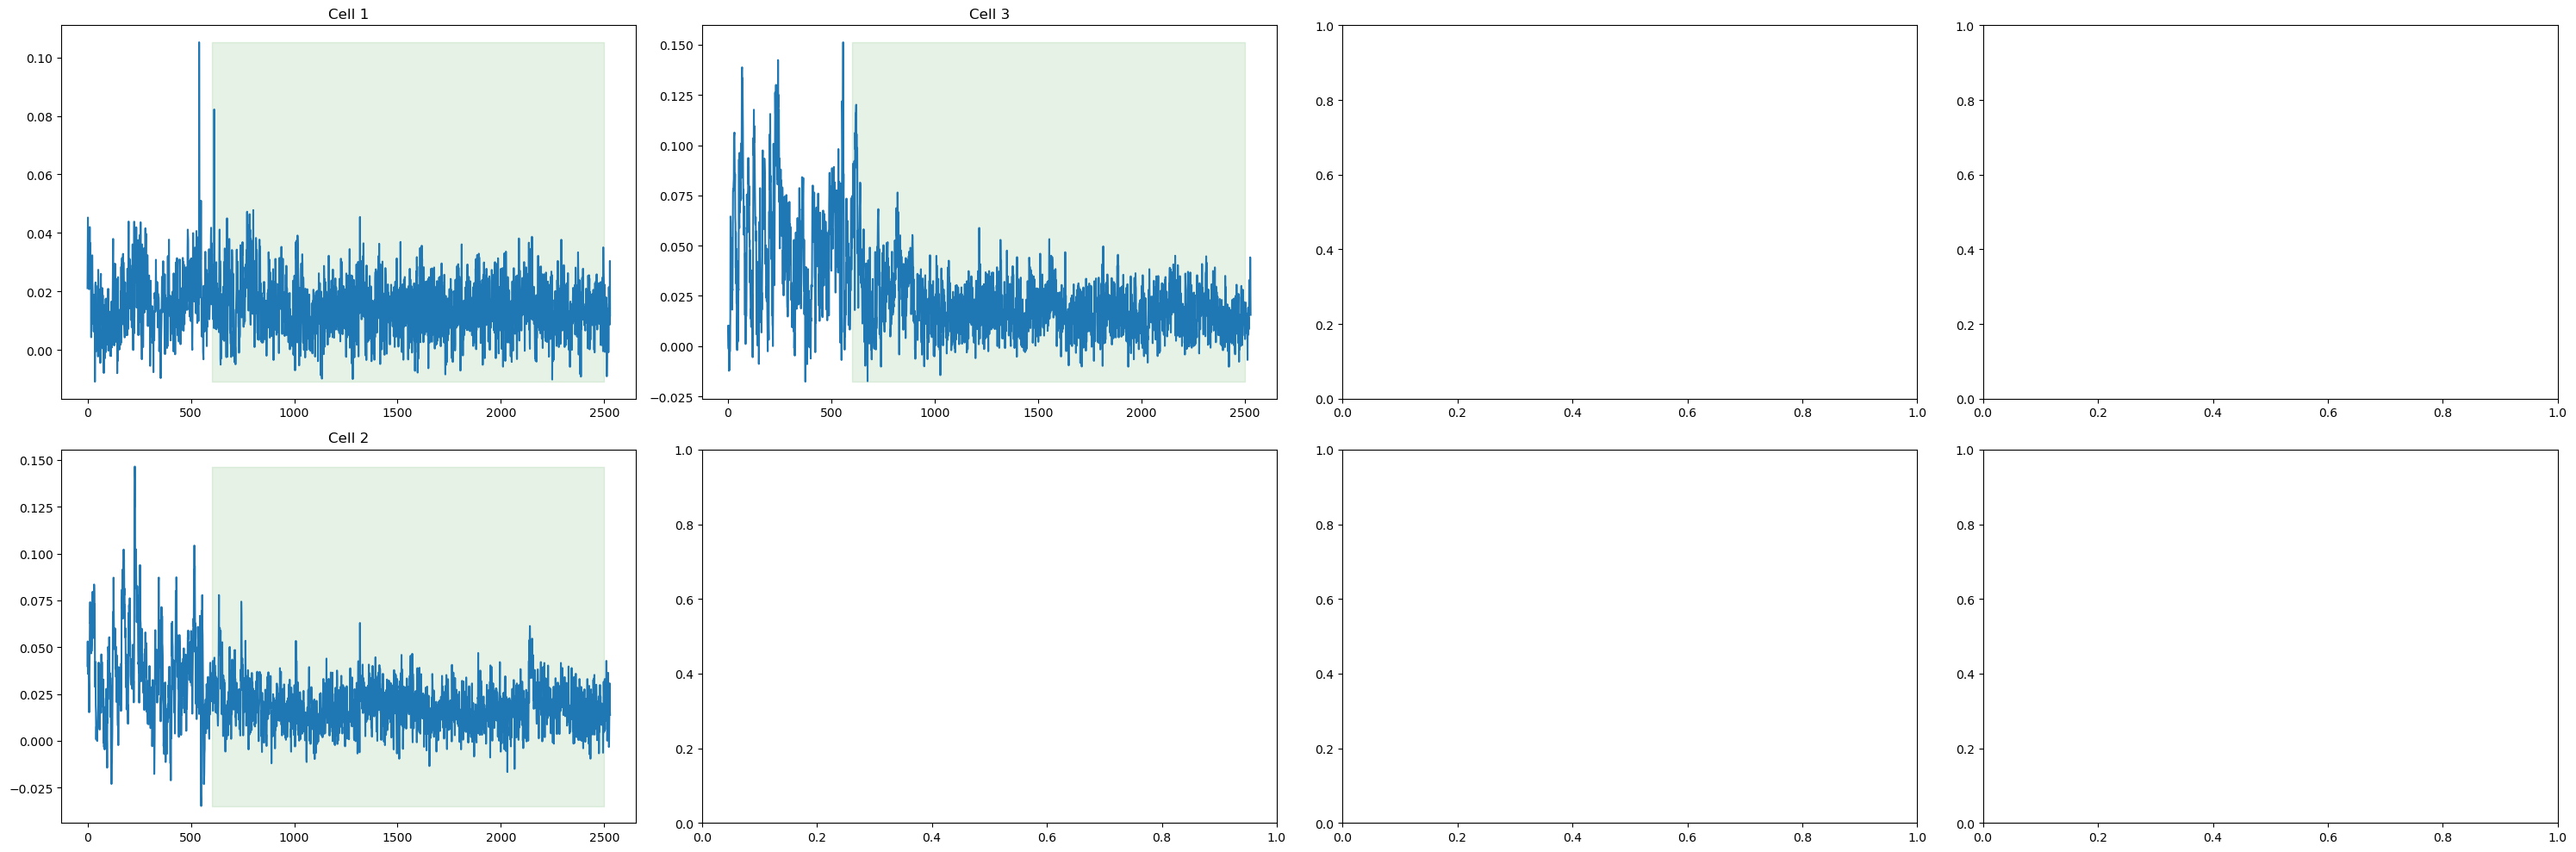

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

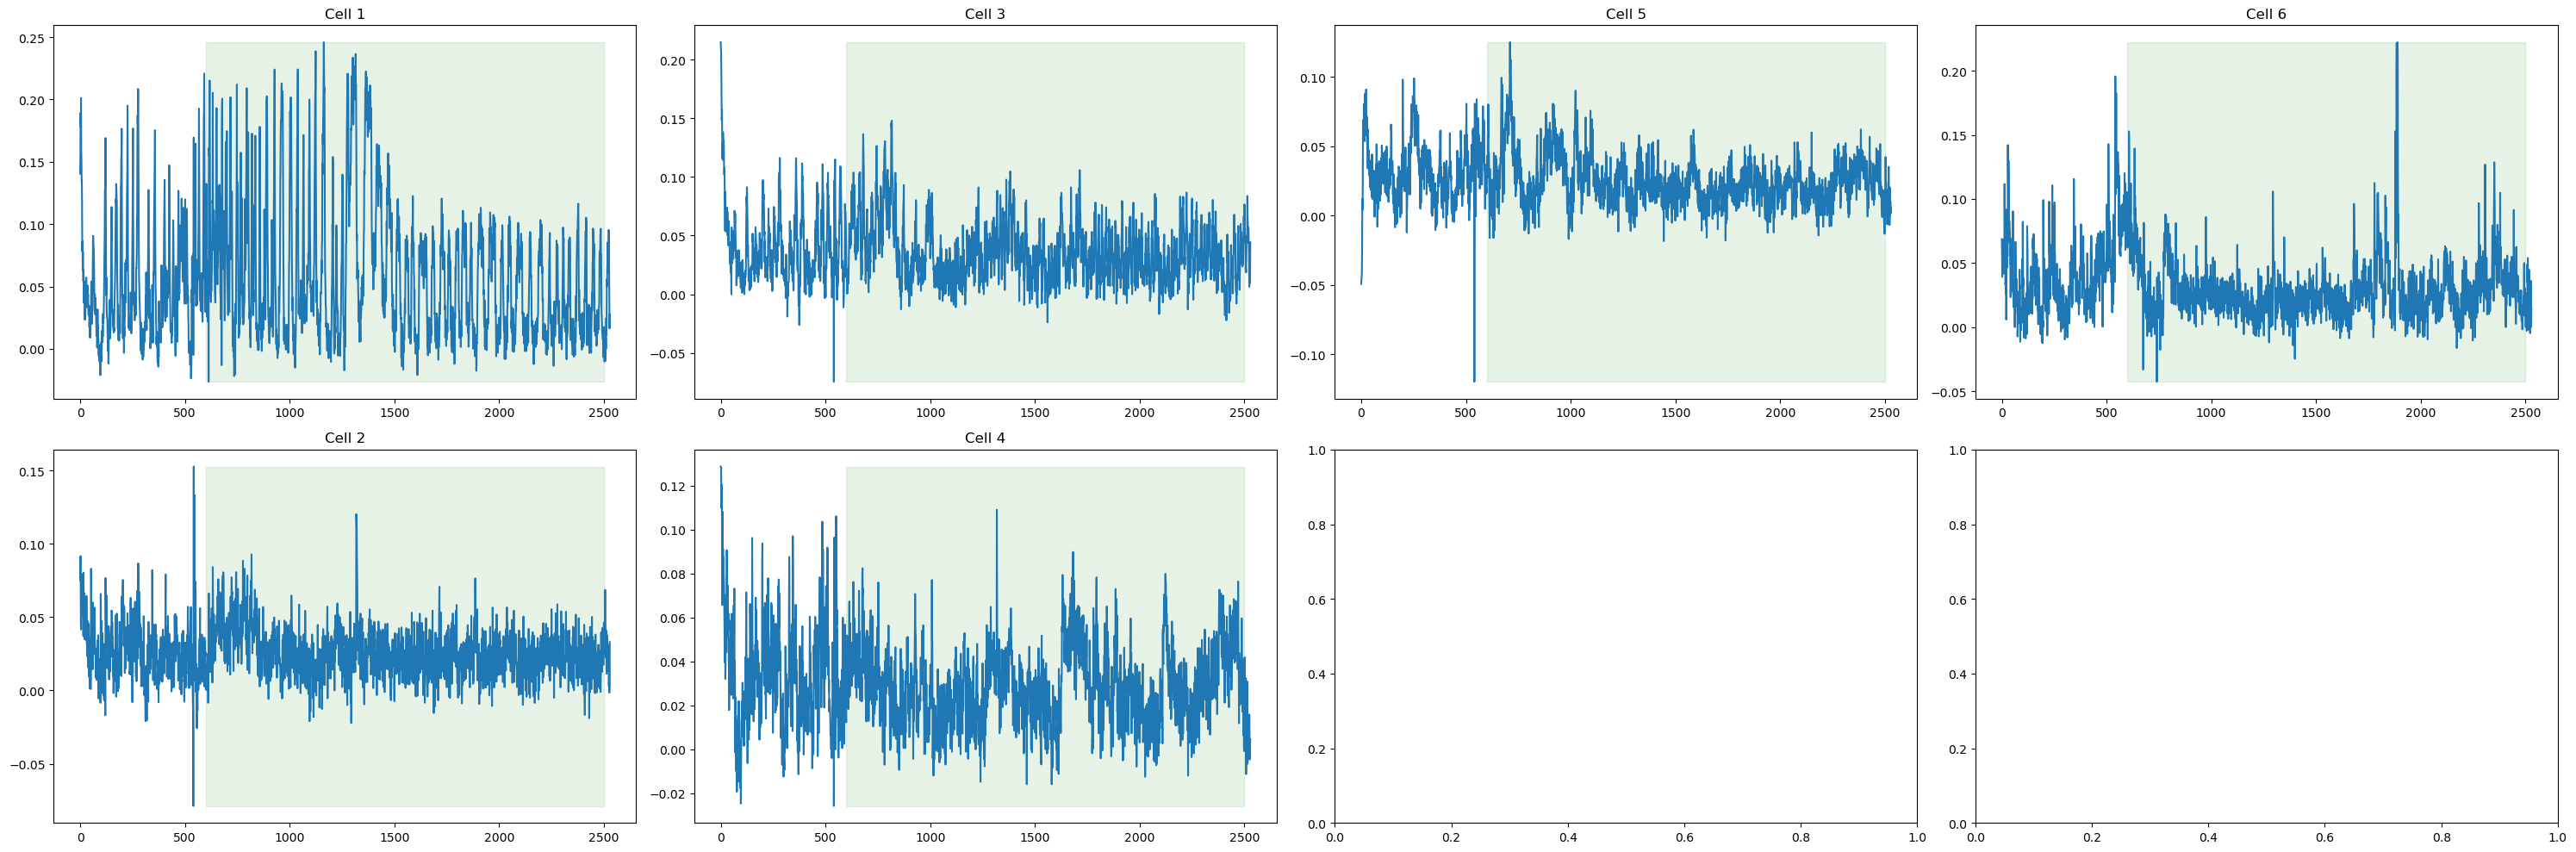

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

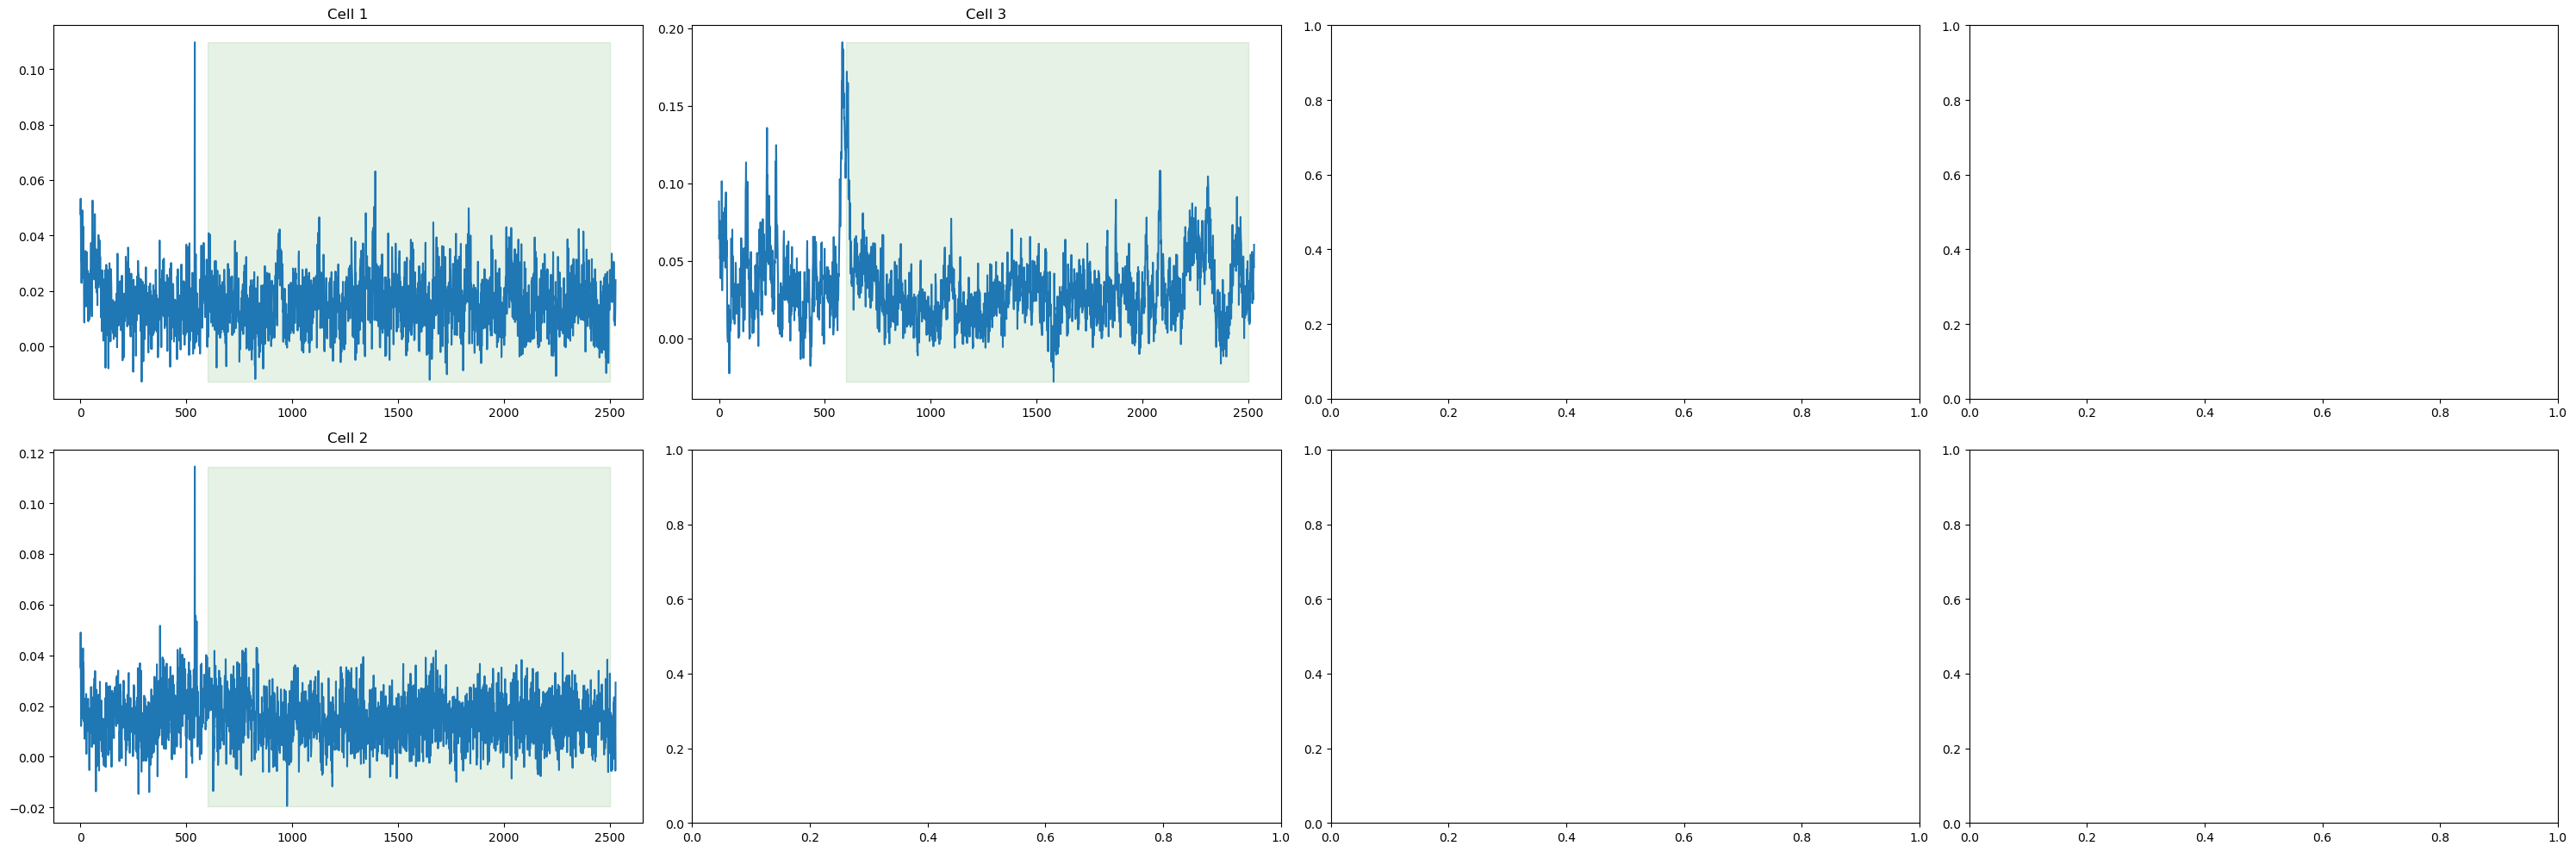

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

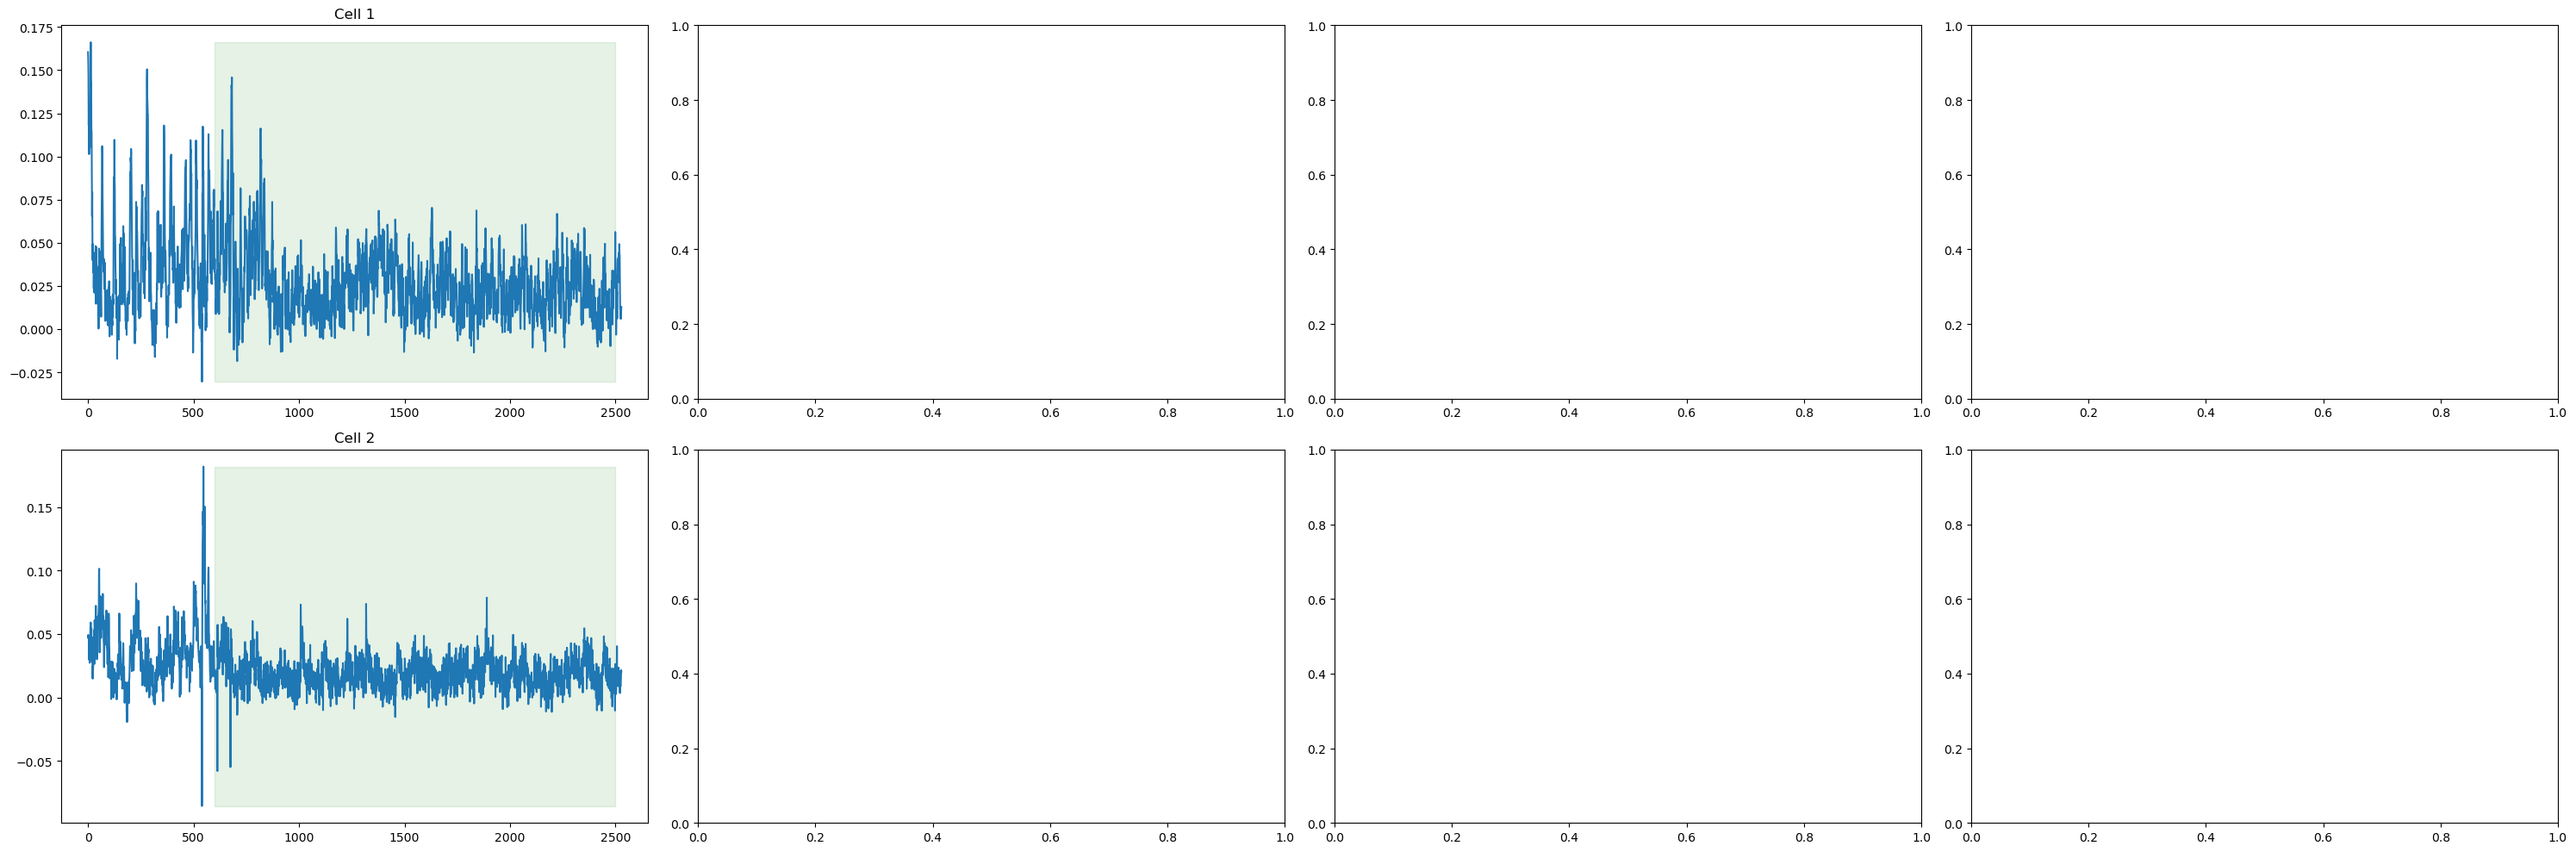

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

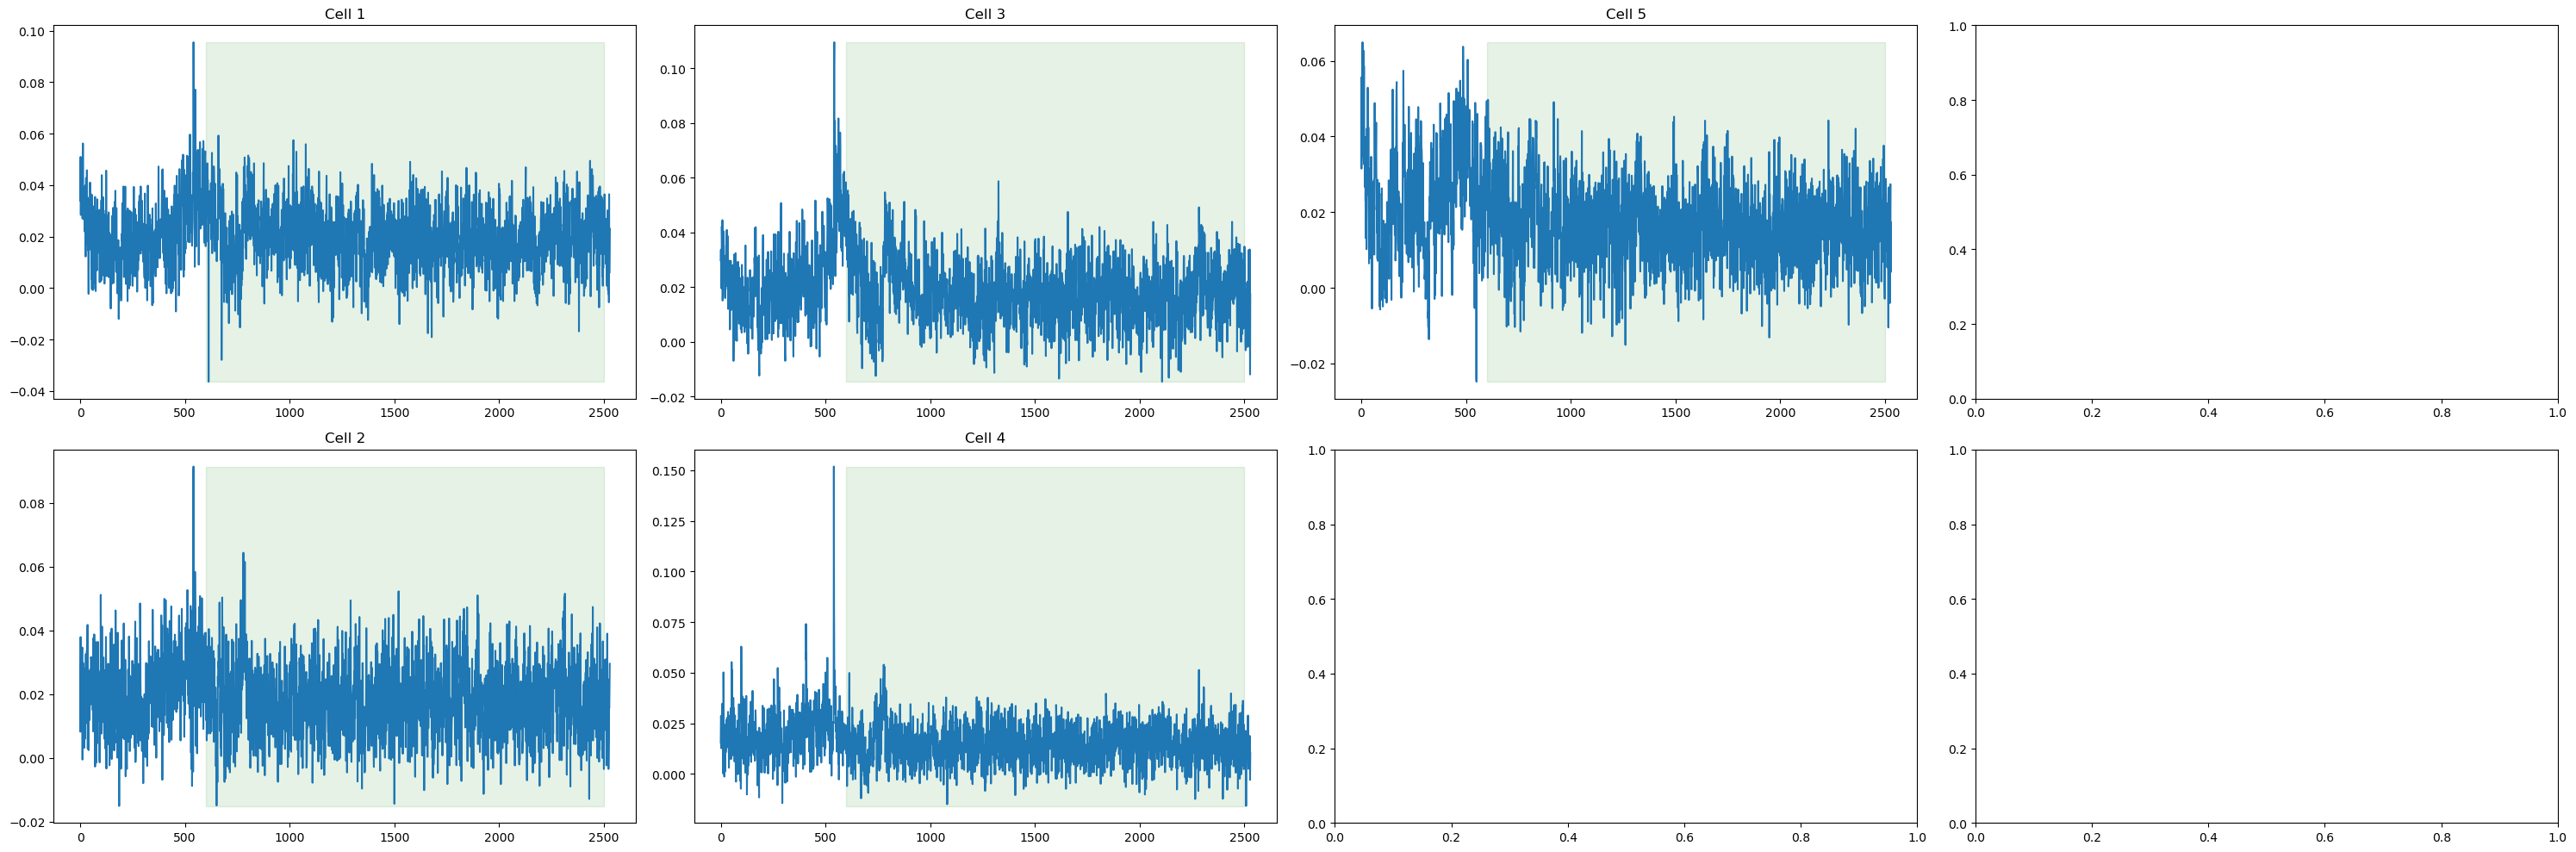

<Figure size 1000x1000 with 0 Axes>

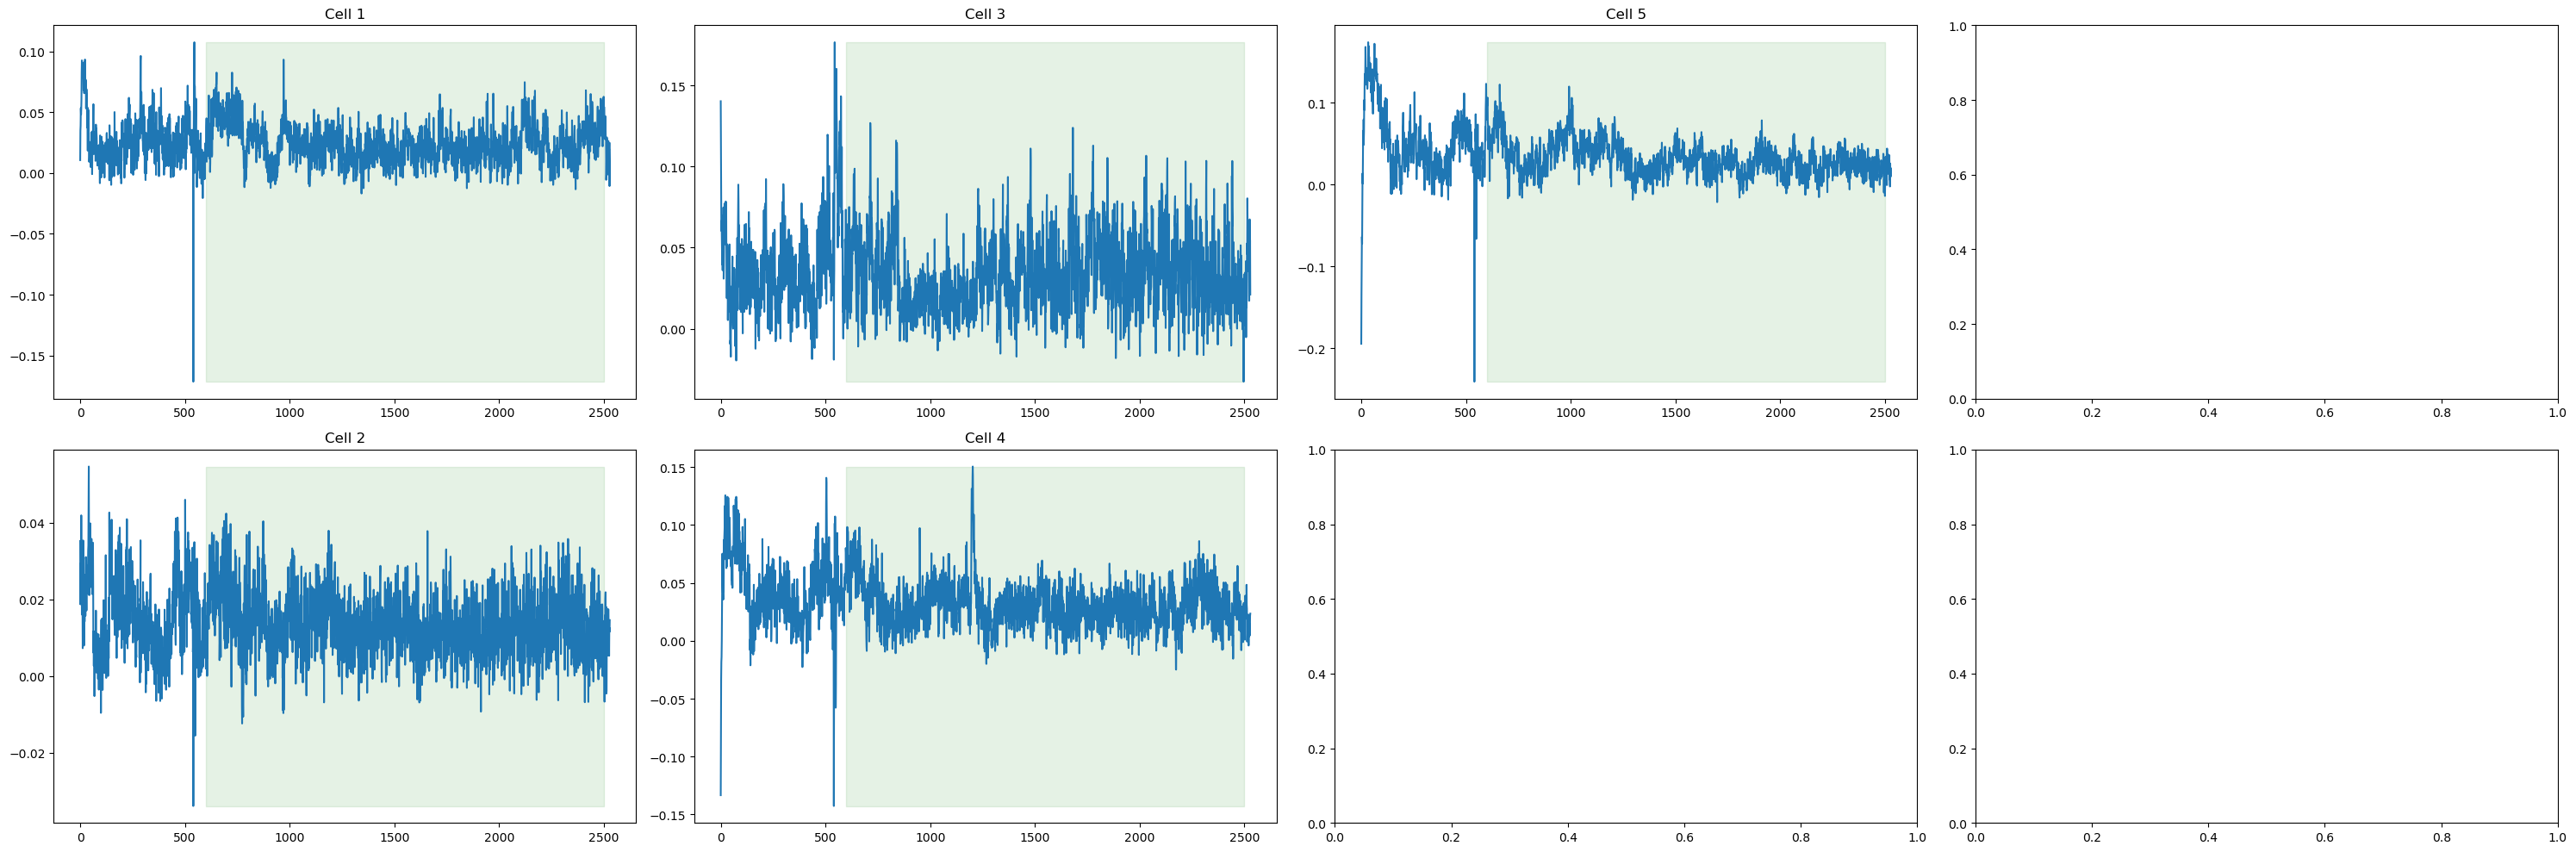

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

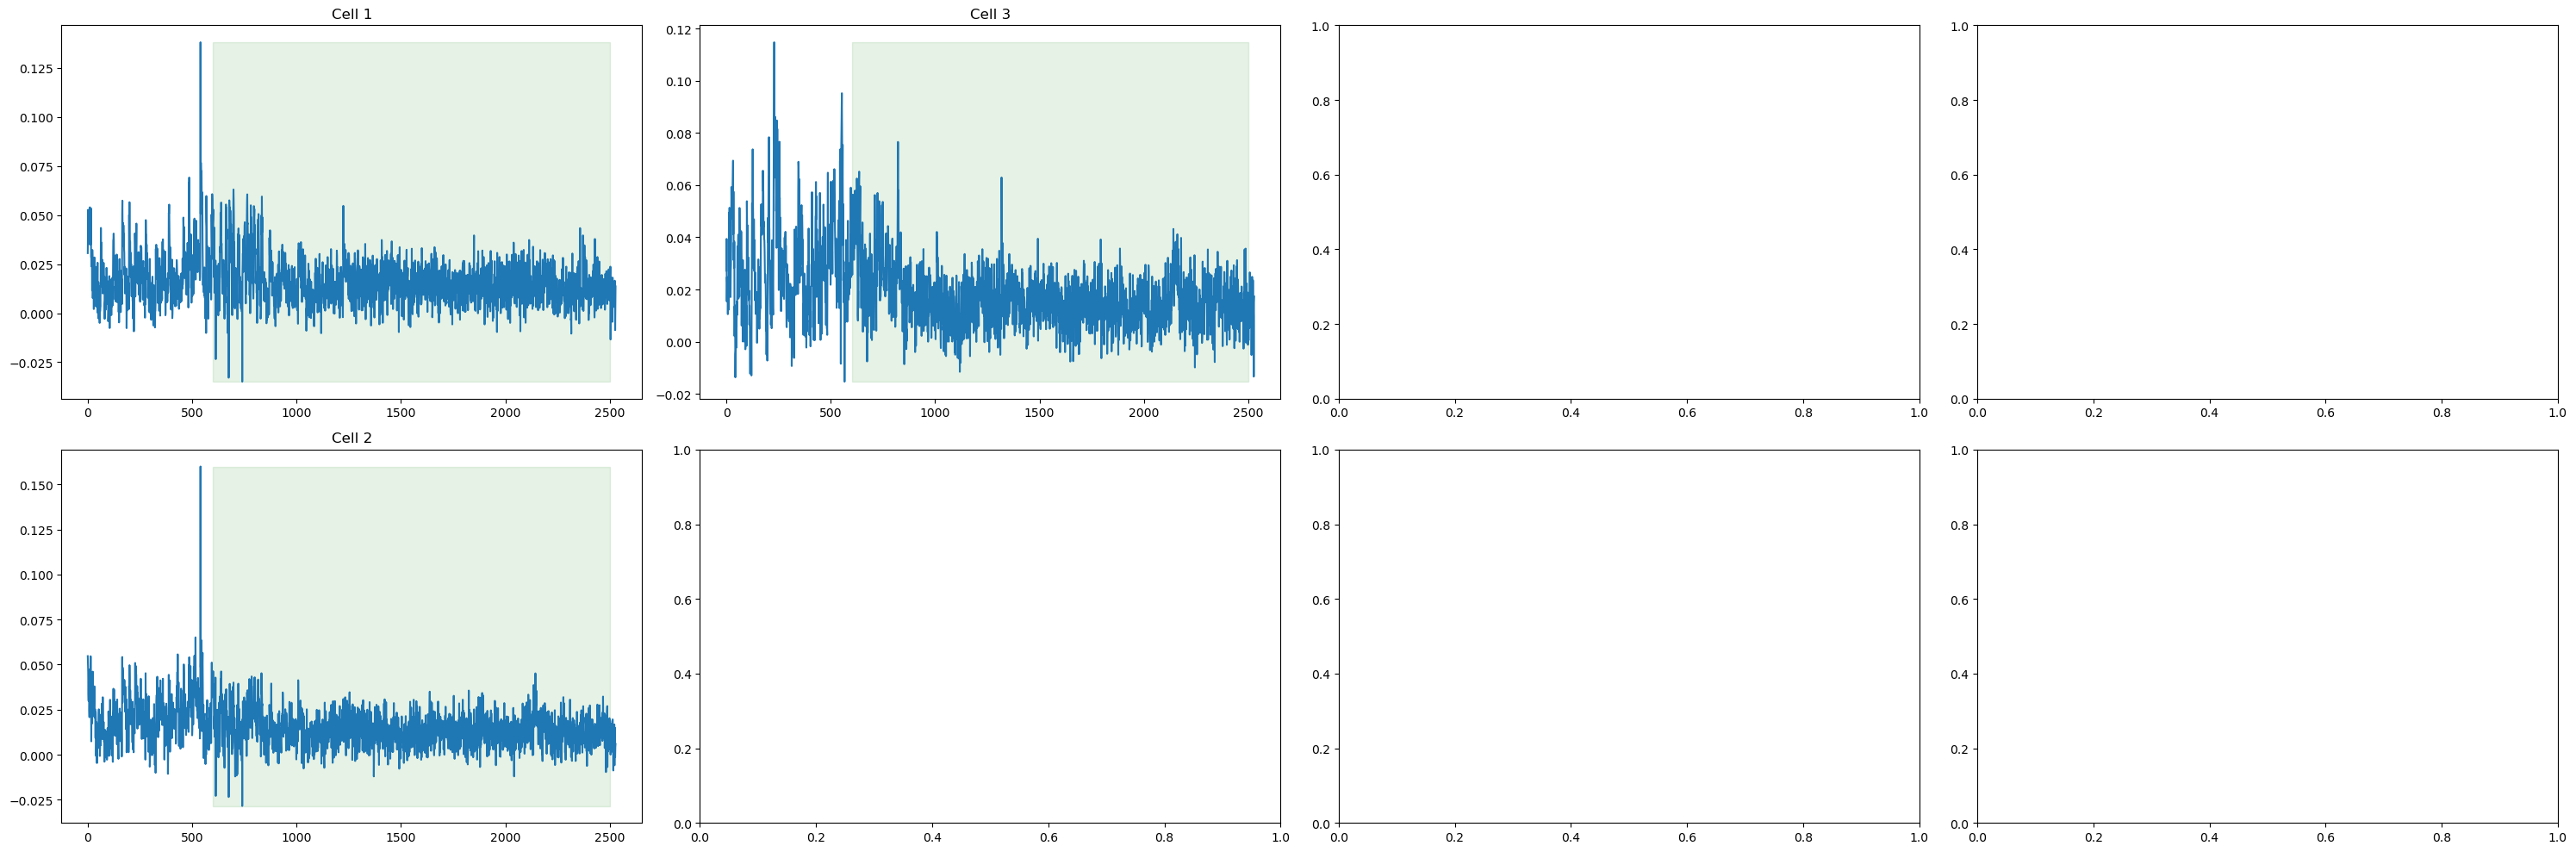

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

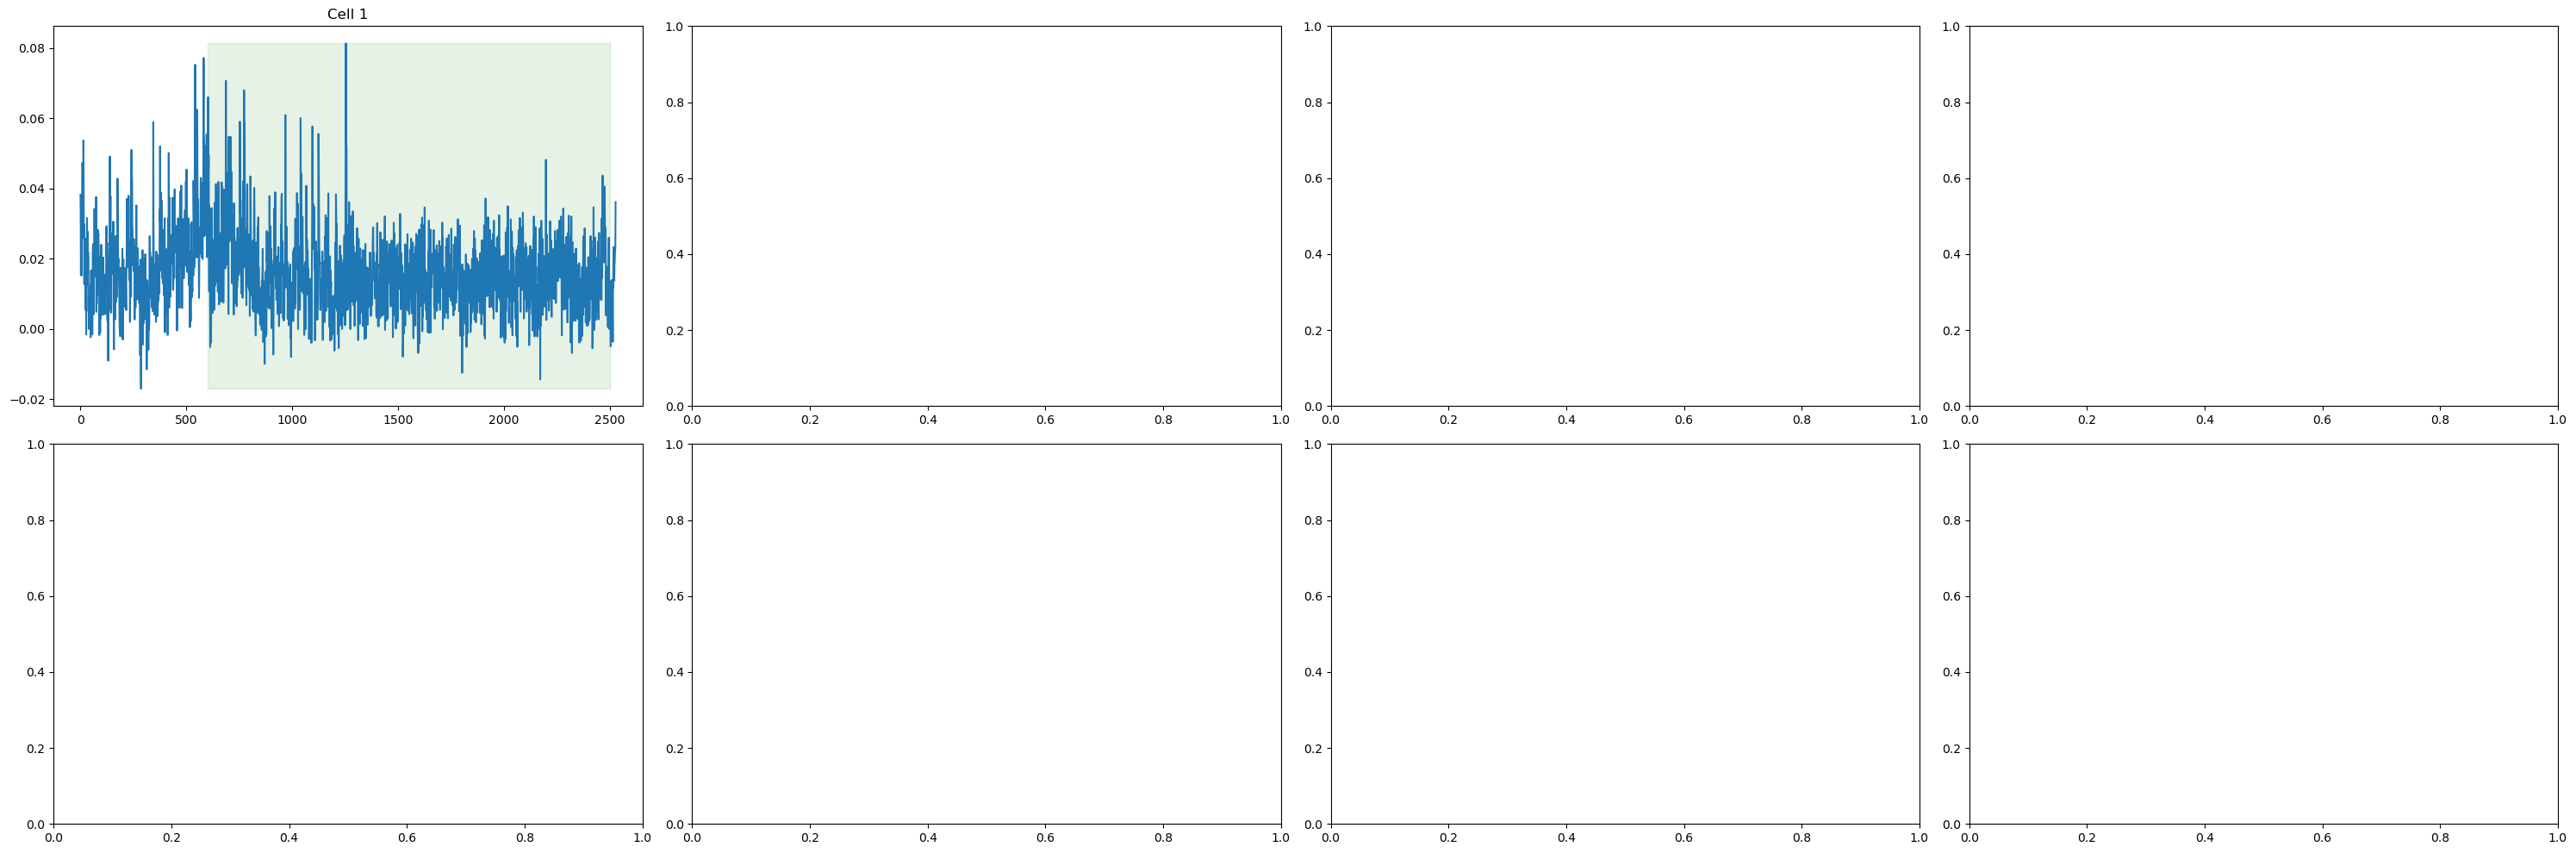

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [16]:
from multiprocessing import Pool
import multiprocessing
import multiprocess as mp
import scipy
import nrrd
from multiprocessing import cpu_count
i = 0

def in_mask(i):


    correct = np.any((mask_LC[X[i],Y[i],Z[i]]==255))

    return correct
for mask in mask_names:
    print(str(i)+"/294")
    directory = mask
    parent_dir = '/Users/marc/Library/CloudStorage/GoogleDrive-mduqueramirez@g.harvard.edu/My Drive/Papers/duque_et_al_ketamine/data_new_round_September_2023_whole_brain_ket/fish_raw/f1_ket_marc_20230926_140425/seg/analysis'
    # Path
    path = os.path.join(parent_dir, directory)
    if os.path.isdir(path) == True:
        pass
    else:
        try:
            os.mkdir(path)
        except:
            pass
        LC, _ = nrrd.read('/Users/marc/Library/CloudStorage/GoogleDrive-mduqueramirez@g.harvard.edu/My Drive/Papers/duque_et_al_ketamine/data_new_round_September_2023_whole_brain_ket/fish_raw/f1_ket_marc_20230926_140425/seg/masks/'+mask+'.nrrd')
        #npad = ((240, 204), (0, 0), (0, 0))
        #b = np.pad(LC, pad_width=npad)
        #this part can be specific for each fish
        mask_LC = np.rot90((LC[:,:,:]),1)
        plt.imshow(np.max(brain_map,axis=2),cmap = 'gray')
        plt.imshow(np.max(mask_LC,axis=2),alpha = 0.5,cmap='viridis')
        plt.savefig(path+'/mask_overlay.pdf')  
        plt.clf()
        num_workers=cpu_count()

        if __name__ == '__main__':
            with mp.Pool(num_workers) as p:
                result=p.map(in_mask, range(len(X)))
                p.close()
               # plt.plot(dff_trace[6,:])
        results=np.asarray(result)
        LC_inds = np.where(results)[0]
        dff_LC = dff[LC_inds,:]
        #dff_LC = dF_new
        i = i +1
        if len(LC_inds) ==0:
            pass
        else:
                #before=results[:,0]
            #after=results[:,1]
            #normalize
            max_ = results_overall[LC_inds]
            #before_ind=np.argsort(before)
            #after_ind=np.argsort(after)|
            max_ind=np.argsort(max_)
            sorted_max=max_[max_ind]
            #plt.figure()
            #plt.plot(max_)
            #plt.figure()
            #plt.plot(sorted_max)
            #plt.ylim(0,1)
            X_pos = []
            Y_pos = []
            Z_pos = []
            selected_inds = []
            fc_early = []
            fc_overall = []
            fc_late = []
            early_active =0
            late_active = 0
            overall_active =0
            for x in LC_inds:
                X_pos.append(X[x][0])
                Y_pos.append(Y[x][0])
                Z_pos.append(Z[x][0])
                fc_early.append(results_early[x])
                fc_late.append(results_late[x])
                fc_overall.append(results_overall[x])
                selected_inds.append(x)
                if results_early[x]>0:
                    early_active = early_active + 1
                if results_late[x]>0:
                    late_active = late_active +1
                if results_overall[x]>0:
                    overall_active = overall_active +1


            total = len(LC_inds)

            df = pd.DataFrame({
            'Mask': mask,
            'X': X_pos,
            'Y':Y_pos,
            'Z':Z_pos,
            'fc_overall':fc_overall,
            'fc_early':fc_early,
            'fc_late':fc_late,
            'ind': selected_inds,
            'total cells': total,
            'early active': early_active,
            'late_active':late_active,
            'overall active':overall_active,
            })
            df.to_csv(path+'/info_analysis.csv')
            #dff_LC = dF_z
            try:
                #plot example dF/Fs
                fig,axs = plt.subplots(2,4)
                fig.set_figheight(10)
                fig.set_figwidth(30)
                axs[0, 0].plot(dff_LC[max_ind[-1],0:])
                axs[0,0].fill_between([600,2500],np.nanmax(dff_LC[max_ind[-1],:]),np.nanmin(dff_LC[max_ind[-1],:]), color='green',alpha=0.1)
                axs[0, 0].set_title("Cell 1")
                axs[1, 0].plot(dff_LC[max_ind[-2],0:])
                axs[1,0].fill_between([600,2500],np.nanmax(dff_LC[max_ind[-2],:]),np.nanmin(dff_LC[max_ind[-2],:]), color='green',alpha=0.1)
                axs[1, 0].set_title("Cell 2")
                axs[1, 0].sharex(axs[0, 0])
                axs[0, 1].plot(dff_LC[max_ind[-3],0:])
                axs[0,1].fill_between([600,2500],np.nanmax(dff_LC[max_ind[-3],:]),np.nanmin(dff_LC[max_ind[-3],:]), color='green',alpha=0.1)
                axs[0, 1].set_title("Cell 3")
                axs[1, 1].plot(dff_LC[max_ind[-4],0:])
                axs[1,1].fill_between([600,2500],np.nanmax(dff_LC[max_ind[-4],:]),np.nanmin(dff_LC[max_ind[-4],:]), color='green',alpha=0.1)
                axs[1, 1].set_title("Cell 4")
                axs[0, 2].plot(dff_LC[max_ind[-5],0:])
                axs[0,2].fill_between([600,2500],np.nanmax(dff_LC[max_ind[-5],:]),np.nanmin(dff_LC[max_ind[-5],:]), color='green',alpha=0.1)
                axs[0, 2].set_title("Cell 5")
                axs[0, 3].plot(dff_LC[max_ind[-6],0:])
                axs[0,3].fill_between([600,2500],np.nanmax(dff_LC[max_ind[-6],:]),np.nanmin(dff_LC[max_ind[-6],:]), color='green',alpha=0.1)
                axs[0, 3].set_title("Cell 6")
                axs[0, 3].sharex(axs[0, 0])
                axs[1, 2].plot(dff_LC[max_ind[-7],0:])
                axs[1,2].fill_between([600,2500],np.nanmax(dff_LC[max_ind[-7],:]),np.nanmin(dff_LC[max_ind[-7],:]), color='green',alpha=0.1)
                axs[1, 2].set_title("Cell 7")
                axs[1, 3].plot(dff_LC[max_ind[-8],0:])
                axs[1,3].fill_between([600,2500],np.nanmax(dff_LC[max_ind[-8],:]),np.nanmin(dff_LC[max_ind[-8],:]), color='green',alpha=0.1)
                axs[1, 3].set_title("Cell 8")

                fig.tight_layout()
                fig.savefig(path+'/dFF_top_cells.pdf')
                plt.clf()

                fig, axs = plt.subplots(2,4)
                fig.set_figheight(10)
                fig.set_figwidth(30)
                axs[0, 0].plot(dff_LC[max_ind[0],0:])
                axs[0,0].fill_between([600,2500],np.nanmax(dff_LC[max_ind[0],:]),np.nanmin(dff_LC[max_ind[0],:]), color='green',alpha=0.1)
                axs[0, 0].set_title("Cell 1")
                axs[1, 0].plot(dff_LC[max_ind[1],0:])
                axs[1,0].fill_between([600,2500],np.nanmax(dff_LC[max_ind[1],:]),np.nanmin(dff_LC[max_ind[1],:]), color='green',alpha=0.1)
                axs[1, 0].set_title("Cell 2")
                axs[1, 0].sharex(axs[0, 0])
                axs[0, 1].plot(dff_LC[max_ind[2],0:])
                axs[0,1].fill_between([600,2500],np.nanmax(dff_LC[max_ind[2],:]),np.nanmin(dff_LC[max_ind[2],:]), color='green',alpha=0.1)
                axs[0, 1].set_title("Cell 3")
                axs[1, 1].plot(dff_LC[max_ind[3],0:])
                axs[1,1].fill_between([600,2500],np.nanmax(dff_LC[max_ind[3],:]),np.nanmin(dff_LC[max_ind[3],:]), color='green',alpha=0.1)
                axs[1, 1].set_title("Cell 4")
                axs[0, 2].plot(dff_LC[max_ind[4],0:])
                axs[0,2].fill_between([600,2500],np.nanmax(dff_LC[max_ind[4],:]),np.nanmin(dff_LC[max_ind[4],:]), color='green',alpha=0.1)
                axs[0, 2].set_title("Cell 5")
                axs[0, 3].plot(dff_LC[max_ind[5],0:])
                axs[0,3].fill_between([600,2500],np.nanmax(dff_LC[max_ind[5],:]),np.nanmin(dff_LC[max_ind[5],:]), color='green',alpha=0.1)
                axs[0, 3].set_title("Cell 6")
                axs[0, 3].sharex(axs[0, 0])
                axs[1, 2].plot(dff_LC[max_ind[6],0:])
                axs[1,2].fill_between([600,2500],np.nanmax(dff_LC[max_ind[6],:]),np.nanmin(dff_LC[max_ind[6],:]), color='green',alpha=0.1)
                axs[1, 2].set_title("Cell 7")
                axs[1, 3].plot(dff_LC[max_ind[7],0:])
                axs[1,3].fill_between([600,2500],np.nanmax(dff_LC[max_ind[7],:]),np.nanmin(dff_LC[max_ind[7],:]), color='green',alpha=0.1)
                axs[1, 3].set_title("Cell 8")

                fig.tight_layout()
                fig.savefig(path+'/dFF_bottom_cells.pdf')
                plt.clf()
            except:
                pass
            #add the heatmap
            a = dff[LC_inds,:]
            final = a[np.mean(-a,axis=1).argsort()]
            plt.tight_layout()
            plt.figure(figsize=(10,10))
            plt.imshow(final,vmin=-0.1,vmax = 0.2,cmap = 'magma', aspect='auto')
            plt.colorbar()
            plt.savefig(path+'/heatmap.pdf')
            plt.clf()